### __This notebook decomposes the volume transport through the Drake Passage (DP), at ~69W, into the components listed below in GFDL models using the DP cross-section /pp model output and creates time series.__

### __Absolute transport__ (T$_{abs}$) : total transport through the DP computed from zonal mass transport (umo) output. Mass transport is the residual transport and is computed at each model time step and is thus representative of the true transport. This is computed for the entire passage and can be subset into particular depth ranges, we compute T$_{abs}$ in the upper 1000 m to compare to observational data.

### _All Thermal Wind Transports (TWT) assume a level of no motion at the ocean bottom and use the model's monthly potential temperature and salinty output for calculations._

### __Thermal Wind Transport__ (TWT$_{\rho}$) : the volume transport from geostrophic velocity, i.e., the component of the flow due to horizonal gradients in the locally referenced potential density in a rotating system. 

### __Thermal Wind Transport from Temperature__ (TWT$_{\theta}$) : The component of TWT$_{\rho}$ due to horizontal gradients in potential temperature.

 ### __Thermal Wind Transport from Salinty__ (TWT$_{S}$) : The component of TWT$_{\rho}$ due to horizontal gradients in salinity (psu).
 
### __Bottom Velocity Transport__ (T$_{BVT}$): Transport due to velocities at the ocean bottom - i.e., the transports not accounted for when assuming a bottom reference velocity of zero in the TWT calculations.


### At each model time step, TWT$_{\rho}$ + T$_{BVT}$ = T$_{abs}$ (the total geostrophic flow) however when using monthly time-averaged velocity output (as opposed to velocity at each time step) we do not expect this calculation to be exact.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
from xgcm import Grid
import momlevel as ml

Matplotlib is building the font cache; this may take a moment.


### Check for xgcm version - this needs to be version 0.6.0

In [2]:
import xgcm
xgcm.__version__

'0.6.0'

### __Load model output for GFDL high-res configurations__
#### __Odiv-183__: p125, c192. Remap scheme PPM_H4 initialized from year 0. Sea ice initial conditions based on year 100 of v3 rather than year 150.
#### __Odiv-184__: p125, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-170__: p25, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-191__: p125, c192. Initialized like Odiv-183/184, remap scheme = P1M_H2, submeso MLE decay time = 10 days. Used as baseline experiment to then tune submeso.
#### __Odiv-200__: p125, c192. Sensitivity of submeso parameterization, submeso MLE decay time = 20 days, with everything else the same as Odiv-191
#### __Odiv-206__: p125, c192. Sensitivity experiment with CM4.0 sea ice albedos initialized from year 180 of Odiv-200 run. 
#### __Odiv-207__: p125, c192. Sensitivity experiment with same sea ice albedos as Odiv-206 but with ESM4 snow-on-land albedos values.
#### __Odiv-209__: p125, c192. Same as Odiv-207 but initialized from year 0.

##### Note: A longer MLE decay time means the submeso MLE scheme hangs around longer to __more strongly effect restratification__. We adjusted to T=20 days (doubled the decay time) from Odiv-191 to Odiv-200 because we wanted stronger ML restratification to cool the model since we are running an 1850 piControl. In CM4-CMIP6, MLE T=30 days. Another "tunable" submesoscale parameter is MLE front-length scale ... a __smaller__ front length enhances the strength of the ML restratificaion. ESM4 used 200m, CM4 used 500m. All Odiv members use length = 500 m, this has not been adjusted.

In [3]:
## There are some issues with the cm4 cmip6 output, so preprocessing is required when reading 
## in the data using xr.open_mfdataset()

def preprocess_cmip6_uo(ds):
    '''slice in the yh_sub02 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub02=slice(6,None)).rename({'yh_sub02':'yh'})
    return dsnew

def preprocess_cmip6_vol(ds):
    '''slice in the yh_sub01 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub01=slice(6,None)).rename({'yh_sub01':'yh'})
    return dsnew

def load_ocean_Drake_Passage(model_config):
    if model_config == 'Odiv-183':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                               combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                               combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                               combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                               combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-184':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-170':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-191':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-200':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    if model_config == 'Odiv-206':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
        
    if model_config == 'Odiv-207':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
        
    if model_config == 'Odiv-209':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
        
    if model_config == 'Odiv-210':
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc &')
        #os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc &')
        ds_T = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*thetao.nc',
                              combine='by_coords', use_cftime=True)
        ds_S = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*so.nc',
                              combine='by_coords', use_cftime=True)
        ds_u = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*uo.nc',
                              combine='by_coords', use_cftime=True)
        ds_umo = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    
    if model_config == 'cmip6-cm4':
        ds_T = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*thetao.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_vol)
        ds_S = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*so.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_vol)
        ds_u = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*uo.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_uo)
        ds_umo = xr.open_mfdataset('/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/5yr/*umo.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess_cmip6_uo)
        ds_drake = xr.merge([ds_T,ds_S,ds_u,ds_umo])
    
    return ds_drake

### Load static fields 

In [4]:
static_om4p125 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')
static_om4p25 = xr.open_dataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_z/ocean_annual_z.static.nc')

### Load om4p125 configuration datasets

In [5]:
## Load om4p125 configurations:
#odiv_183_184 = xr.concat([load_ocean_Drake_Passage('Odiv-183'),
#                          load_ocean_Drake_Passage('Odiv-184')],
#                          dim='time').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

#odiv_191 = load_ocean_Drake_Passage('Odiv-191').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

#odiv_200 = load_ocean_Drake_Passage('Odiv-200').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

#odiv_206 = load_ocean_Drake_Passage('Odiv-206').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

#odiv_207 = load_ocean_Drake_Passage('Odiv-207').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

odiv_209 = load_ocean_Drake_Passage('Odiv-209').rename({'yh_sub01':'yh',
                                              'xh_sub01':'xh',
                                              'xq_sub01':'xq',
                                              }).isel(yh=slice(6,None))

### Load om4p25 configuration datasets

In [6]:
## Load om4p25 configurations:
#odiv_170 = load_ocean_Drake_Passage('Odiv-170').rename({'yh_sub01':'yh',
#                                              'xh_sub01':'xh',
#                                              'xq_sub01':'xq',
#                                              }).isel(yh=slice(6,None))

odiv_210 = load_ocean_Drake_Passage('Odiv-210').rename({'yh_sub01':'yh',
                                              'xh_sub01':'xh',
                                              'xq_sub01':'xq',
                                              }).isel(yh=slice(6,None))

cmip6_cm4 = load_ocean_Drake_Passage('cmip6-cm4').rename({'xh_sub01':'xh',
                                                          'xq_sub01':'xq',         
                                              })

### Define Constants and Functions used by all

In [7]:
def annual_mean(array):
    """
    weight by days in each month
    """
    # Determine month length
    month_length = array.time.dt.days_in_month
    # Calculate weights
    wgts = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    # Setup our masking for nan values
    cond = array.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    # Calculate the numerator
    array_sum = (array * wgts).resample(time="AS").sum(dim="time")
    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    # Return the weighted average
    return array_sum / ones_out

g = 9.81       ## m s-2 
rho_0 = 1035.  ## kg m-3 Ref density used in MOM6

def compute_coriolis(darray):
    """
    Calculate the Coriolis frequency (f) if not provided in the ocean_static file
    
    Parameters
    -----------
    darray: xarray.DataArray
        Two dimensional data array containing model's geolat variable
    
    Returns
    -----------
    f: xarray.DataArray
        Two dimensional data array containing computed Corilis parameter f. 
    """
    
    w = 7.292124e-5                             #Earth's angular velocity in rad s-1 (2*pi / T, where T is Earth's sidereal period, 23 hrs, 56 min, 4 sec.)
    lat_rad = (darray.geolat_c)*((2*np.pi)/360) #np.sin takes an angle in radians, so need to convert lat from degrees to rad.
    f = (2*w)*np.sin(lat_rad)
    return f

def compute_dz_between_u_points(thk):
    
    """
    Calculate the discrete vertical distance (dz) between two points where 
    the zonal geostrophic velocities are located that are derived from our
    potential density field. These vertically are on the cell centers (z_l)
    , but we must account for partial cells are the ocean bottom.
       
    For du/dz, the vertical shear, the dz refers to the depth in m between
    our two u velocities, this is NOT equivalent to grid cell thickness. 
    The correct dz between u points is computed using this function.
    
    Parameters
    ----------
    thk : xarray.DataArray
        Data Array containing interpolated thickness on xh,yq points
        which as already been subset in yq for the Drake Passage
        
    Returns
    ----------
    dz_u_points: xarray.DataArray
        Data Array containing the distance in m between zonal 
        geostrophic velocities to be used in Thermal Wind Transport calculation
    """
    
    kmax = thk.shape[0]                             ## of z levels
    zl  = 0.0 * thk[:]                              ## Thickness is zero everywhere 
    zl[0] = 0.5 * thk[0]                            ## Multiple first element by 0.5 .... first element is the top cell

    k = 1
    while k < kmax:
        zl[k] = (0.5*(thk[k-1])) + (0.5*(thk[k]))
        k=k+1

    dz_u_points = xr.DataArray(zl,dims=thk.dims,coords=thk.coords)
    
    return dz_u_points

def slice_static_array(sliced_array,static_array):
    """ 
    Slice the ocean static array along the Y dimension so that it can be used to 
    create xgcm grid object to be used with the Drake Passage post-processed model
    output which is provided only at the Drake Passage cross-section.
    
    Parameters
    ----------
    sliced_array : xarray.DataArray
        Data Array containing drake passage subset data.
        
    static_array : xarray.DataArray
        Data Array containing full ocean static field that
        you wish to slice.
        
    Returns
    ----------
    static_sliced_array: xarray.DataArray
        Data Array containing the static field sliced in the Y dimensions to be used
        with the post processed Drake Passage subset data.
    
    """
    
    ## Find yq point adjacent to the first yh point in our rho array:
    y_south_0 = sliced_array.yh[0]
    y_south_1 = sliced_array.yh[1]
    diff_y_south = np.abs(y_south_1 - y_south_0)
    yq_point_south = y_south_0 + (diff_y_south/2)

    ## Find yq point adjacent to the last yh point in our rho array:
    y_north_1 = sliced_array.yh[-1]
    y_north_0 = sliced_array.yh[-2]
    diff_y_north = np.abs(y_north_1 - y_north_0)
    yq_point_north = y_north_1 + (diff_y_north/2)
    
    ## Find index where yq points are:
    yq_south_idx = np.abs(static_array.yq - yq_point_south.values).argmin()
    yq_north_idx = np.abs(static_array.yq - yq_point_north.values).argmin()
    yh_south_idx = np.abs(static_array.yh - y_south_0.values).argmin()
    yh_north_idx = np.abs(static_array.yh - y_north_1.values).argmin()

    ## We must slice our static array to be equal to the section
    ## defined from yq=288 to yq=578, (so indexed as 578+1)
    static_sliced_array = static_array.isel(yq=slice(yq_south_idx.values,yq_north_idx.values + 2),
                                            yh=slice(yh_south_idx.values,yh_north_idx.values+1))
    
    
    return static_sliced_array

### Compute TWT$_\rho$

Geostrophic Balance:
\begin{equation}
u_g = -\frac{1}{\rho_0 f} \frac{\partial p}{\partial y}
\end{equation}

Thermal Wind Equation:
\begin{equation}
\frac{\partial u}{\partial z} = \frac{g}{\rho_0 f}\frac{\partial \rho}{\partial y}
\end{equation}

Thermal Wind Velocity (or geostrophic velocity, u_geo), assuming a level of no motion (zero velocity) at ocean bottom:

\begin{equation}
u_{geo}  = \int_{0}^{H} \frac{g}{\rho_0 f}\frac{\partial \rho}{\partial y} dz + u_0
\end{equation}

\begin{equation}
u_{geo} = TWT_{\rho}
\end{equation}

In [8]:
def compute_thermal_wind(static_sliced_array,TS_dataset,grid_object):
    
    # Coriolis defined at same points that ddens_dy will end up:
    f = grid_object.interp(static_sliced_array.Coriolis,'X',boundary='fill').sel(xh=TS_dataset.xh.values,method='nearest')
    
    # Compute the locally referenced potential density -- 
    # this is equivalent to in-situ density at a specific point.
    # Rho is computed using the momlevel.derived.calc_rho funtion 
    # documented here:https://momlevel.readthedocs.io/en/latest/eos.html 
    # This computes density using the Wright 1997, J. Atmos. Ocean. Tech., 
    # 14, 735 - 740 equation of state (EOS). Pressure is approximated as 
    # depth * 1e4 (to get pressure in Pa).
    
    rho_array = ml.derived.calc_rho(TS_dataset.thetao,
                                    TS_dataset.so,
                                    TS_dataset.z_l*1e4)
    
    # Discrete difference of density along Y axis:
    diff_dens = grid_object.diff(rho_array,'Y',boundary='fill')
    
    # Distance between yh points:
    dy = static_sliced_array.dyCv.sel(xh=rho_array.xh.values,method='nearest')
    
    # Difference in density / distance of yh points
    ddens_dy = (diff_dens/dy)
    
    # thickness between z levels accounting for partial cells at ocean bottom:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_sliced_array.deptho)
    thk = thk.where(thk>0).sel(xh=rho_array.xh.values,method='nearest')
    thk_interp = grid_object.interp(thk,'Y',boundary='fill')
    
    dz_u_points = compute_dz_between_u_points(thk_interp)
    
    ddens_dy_times_dz = (ddens_dy)*dz_u_points     
    constant = g / (rho_0*f)
    
    ## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
    ugeo_intermed = (constant*ddens_dy_times_dz).squeeze().transpose("z_l","yq","time")   
    ugeo = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

    ## Compute total volume transport, U:
    U_Sv = (ugeo*thk_interp*dy)/10**6
    TWT_Sv = U_Sv.sum(dim=(['yq','z_l']))
    TWT_Sv_upper_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
    TWT_Sv_below_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))
    
    return ugeo, TWT_Sv, TWT_Sv_upper_1000, TWT_Sv_below_1000

### Decompose TWT$_{\rho}$ into a contribution from horizontal gradients in S (TWT$_{S}$) and from $\theta$ (TWT$_{\theta}$)

\begin{equation}
\frac{\partial \rho}{\partial y} = \rho_0 * (-\alpha*\frac{\partial \theta}{\partial y} + \beta*\frac{\partial S}{\partial y})
\end{equation}

Thermal Expansion Coefficient:
\begin{equation}
\alpha = -\frac{1}{\rho_0}\frac{\partial \rho}{\partial \theta}
\end{equation}

\begin{equation}
-\alpha*\rho_0*\frac{\partial \theta}{\partial y} = \frac{\partial \rho}{\partial y}
\end{equation}

\begin{equation}
\frac{\partial u}{\partial z} = \frac{g}{\rho_0 f}  (-\alpha*\rho_0*\frac{\partial \theta}{\partial y}) 
\end{equation}

\begin{equation}
u_{geo,\theta}  = \int_{0}^{H} \frac{g}{\rho_0 f}(-\alpha*\rho_0*\frac{\partial \theta}{\partial y}) dz + u_0
\end{equation}

Haline Contraction Coefficient:
\begin{equation}
\beta = \frac{1}{\rho_0}\frac{\partial \rho}{\partial S}
\end{equation}

\begin{equation}
\beta*\rho_0*\frac{\partial S}{\partial y} = \frac{\partial \rho}{\partial y}
\end{equation}

\begin{equation}
\frac{\partial u}{\partial z} = \frac{g}{\rho_0 f}  (\beta*\rho_0*\frac{\partial S}{\partial y}) 
\end{equation}

\begin{equation}
u_{geo,S}  = \int_{0}^{H} \frac{g}{\rho_0 f}(\beta*\rho_0*\frac{\partial S}{\partial y}) dz + u_0
\end{equation}

Summation of transport due to temperature gradients and salinity gradients should approximate transport due to density gradients:
\begin{equation}
u_{geo} = u_{geo,\theta} + u_{geo,S}  
\end{equation}

### Define functions used to compute Thermal Wind Transport (TWT) and Bottom Velocity Transport (BVT)

In [9]:
def compute_thermal_wind_salinity(static_sliced_array,TS_dataset,grid_object):
    # Coriolis defined at same points that ddens_dy will end up:
    f = grid_object.interp(static_sliced_array.Coriolis,'X',boundary='fill').sel(xh=TS_dataset.xh.values,method='nearest')
    
    # alpha defined at the same ponits that dT_dy will end up:
    beta_array = ml.derived.calc_beta(TS_dataset.thetao,
                                      TS_dataset.so,
                                      TS_dataset.z_l*1e4).squeeze()
    
    beta = grid_object.interp(beta_array,'Y',boundary='fill')
    
    # Discrete difference of density along Y axis:
    diff_so = grid_object.diff(TS_dataset.so,'Y',boundary='fill')
    
    # Distance between yh points:
    dy = static_sliced_array.dyCv.sel(xh=TS_dataset.xh.values,method='nearest')
    
    # Difference in density / distance of yh points
    dso_dy_beta = beta*(diff_so/dy)
    
    # thickness between z levels accounting for partial cells at ocean bottom:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_sliced_array.deptho)
    thk = thk.where(thk>0).sel(xh=TS_dataset.xh.values,method='nearest')
    thk_interp = grid_object.interp(thk,'Y',boundary='fill')
    
    dz_u_points = compute_dz_between_u_points(thk_interp)
    #dz_u_points = thk_interp
    
    dso_dy_times_dz = dso_dy_beta*dz_u_points     
    constant = g / (rho_0*f)
    
    ## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
    ugeo_intermed = (constant*dso_dy_times_dz).squeeze().transpose("z_l","yq","time")   
    ugeo = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

    ## Compute total volume transport, U:
    U_Sv = (ugeo*thk_interp*dy)/10**6
    TWT_Sv = U_Sv.sum(dim=(['yq','z_l']))
    TWT_Sv_upper_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
    TWT_Sv_below_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))
    
    return ugeo*1035, TWT_Sv*1035, TWT_Sv_upper_1000*1035, TWT_Sv_below_1000*1035


def compute_thermal_wind_temp(static_sliced_array,TS_dataset,grid_object):
    # Coriolis defined at same points that dT_dy will end up:
    f = grid_object.interp(static_sliced_array.Coriolis,'X',boundary='fill').sel(xh=TS_dataset.xh.values,method='nearest')
    
    # alpha defined at the same ponits that dT_dy will end up:
    alpha_array = ml.derived.calc_alpha(TS_dataset.thetao,
                                       TS_dataset.so,
                                       TS_dataset.z_l*1e4).squeeze()
    
    alpha = grid_object.interp(alpha_array,'Y',boundary='fill')
    
    # Discrete difference of density along Y axis:
    diff_T = grid_object.diff(TS_dataset.thetao,'Y',boundary='fill')
    
    # Distance between yh points:
    dy = static_sliced_array.dyCv.sel(xh=TS_dataset.xh.values,method='nearest')
    
    # Difference in density / distance of yh points
    dT_dy_alpha = (diff_T/dy)*alpha
    
    # thickness between z levels accounting for partial cells at ocean bottom:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_sliced_array.deptho)
    thk = thk.where(thk>0).sel(xh=TS_dataset.xh.values,method='nearest')
    thk_interp = grid_object.interp(thk,'Y',boundary='fill')
    
    dz_u_points = compute_dz_between_u_points(thk_interp)
    #dz_u_points = thk_interp
    
    dT_dy_times_dz = (dT_dy_alpha)*dz_u_points     
    constant = g / (rho_0*f)
    
    ## This is our du field which then must be cumulatively summed vertically from bottom to top to get the zonal geostrophic velocity ugeo:
    ugeo_intermed = (constant*dT_dy_times_dz).squeeze().transpose("z_l","yq","time")   
    ugeo = ugeo_intermed.reindex(z_l=ugeo_intermed.z_l[::-1]).cumsum('z_l')

    ## Compute total volume transport, U:
    U_Sv = (ugeo*thk_interp*dy)/10**6
    TWT_Sv = U_Sv.sum(dim=(['yq','z_l']))
    TWT_Sv_upper_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(0,1000)).sum(dim=(['yq','z_l']))
    TWT_Sv_below_1000 = U_Sv.reindex(z_l=U_Sv.z_l[::-1]).sel(z_l=slice(1000,None)).sum(dim=(['yq','z_l']))
    
    return ugeo*1035*-1, TWT_Sv*1035*-1, TWT_Sv_upper_1000*1035*-1, TWT_Sv_below_1000*1035*-1

In [10]:
def compute_bottom_velocity_transport(static_array,zonal_velocity_array,TS_dataset,grid_object):
    ### Isolate bottom velocities
    uo_bottom = zonal_velocity_array.ffill('z_l').isel(z_l=-1)
    
    ### Only have thickness at tracer points, so to use for velocity calculation, we need
    ### to interpolate thickness to xq points:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_array.deptho)
    thk_interp = grid_object.interp(thk,'X',boundary='fill')
    
    ### locate index of xq value:
    xloc = zonal_velocity_array.xq.values
    xloc_idx = np.abs(static_array.xq - xloc).argmin()
    
    ### Isolate thkness and dy in Drake region
    thk_interp_drake = thk_interp.isel(xq=xloc_idx)
    total_depth_drake = thk_interp_drake.sum(dim='z_l')
    
    ### Compute the bottom velocity transport
    dy = static_array.dyCu.isel(xq=xloc_idx)
    U_bottom = total_depth_drake*dy*uo_bottom
    BVT_Sv = U_bottom.sum(dim=(['yh']))/10**6
    
    ### For plot of BV velocity expanded through the water column
    uo_bottom_mask = zonal_velocity_array.where(zonal_velocity_array == uo_bottom)
    bottom_vel_filled = uo_bottom_mask.bfill('z_l')

    return bottom_vel_filled, BVT_Sv

In [11]:
def compute_transport_from_velocity(static_array,zonal_velocity_array,TS_dataset,grid_object):
    ### locate index of xq value:
    ### Only have thickness at tracer points, so to use for velocity calculation, we need
    ### to interpolate thickness to xq points:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_array.deptho)
    thk_interp = grid_object.interp(thk,'X',boundary='fill')
    
    ### locate index of xq value:
    xloc = zonal_velocity_array.xq.values
    xloc_idx = np.abs(static_array.xq - xloc).argmin()
    
    ### Isolate thkness and dy in Drake region
    thk_interp_drake = thk_interp.isel(xq=xloc_idx)
    
    ### Compute the bottom velocity transport
    dy = static_array.dyCu.isel(xq=xloc_idx)
    
    Vol_Trans = zonal_velocity_array * dy * thk_interp_drake
    
    return Vol_Trans

def compute_transport_from_velocity(static_array,zonal_velocity_array,TS_dataset,grid_object):
    ### locate index of xq value:
    ### Only have thickness at tracer points, so to use for velocity calculation, we need
    ### to interpolate thickness to xq points:
    thk = ml.derived.calc_dz(TS_dataset.z_l,TS_dataset.z_i,static_array.deptho)
    thk_interp = grid_object.interp(thk,'X',boundary='fill')
    
    ### locate index of xq value:
    xloc = zonal_velocity_array.xq.values
    xloc_idx = np.abs(static_array.xq - xloc).argmin()
    
    ### Isolate thkness and dy in Drake region
    thk_interp_drake = thk_interp.isel(xq=xloc_idx)
    
    ### Compute the bottom velocity transport
    dy = static_array.dyCu.isel(xq=xloc_idx)
    
    Vol_Trans = zonal_velocity_array * dy * thk_interp_drake
    
    return Vol_Trans

### Compute Thermal Wind Transport (TWT) and Bottom Velocity Transport for Odiv183_184

##### First we define grid objects for each configuration

###### CM4's ocean component, MOM6, uses an Arakawa-C Grid, where tracers are located at the cell centers, u falls on the interface of the tracer cells in the zonal direction (left T cell face), and v falls on the interface of the tracer cell in the meridional direction (front T cell face). To compute the TWT, we need to use xgcm to perform interpolation and differencing, so we must first create a grid object for each configuration.

###### For the TWT calculation, we need to define the grid object using a static_array that is sliced to match our Drake Passage post processed sliced region, so we run it through the __static_slice_array__ function first.

In [12]:
static_sliced_om4p125 = slice_static_array(odiv_209,static_om4p125)
static_sliced_om4p25 = slice_static_array(odiv_210,static_om4p25)

grid_sliced_p125 = Grid(static_sliced_om4p125, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

grid_sliced_p25 = Grid(static_sliced_om4p25, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

# There is an issue with the xh and xq nominal coordinates here -- adjustment is needed
# before defining the grid object for the om4p125 configurations.
# We replace the nominal xq and yh by indices so that Xarray does not get confused.
# We never need xq and yq for actual calculations, so filling these arrays with any value
# will not going to change any results.

static_om4p125_newidx = static_om4p125.copy()
static_om4p125_newidx["xh"] = xr.DataArray(np.arange(len(static_om4p125["xh"])), dims=["xh"])
static_om4p125_newidx["xq"] = xr.DataArray(np.arange(len(static_om4p125["xq"])), dims=["xq"])
static_om4p125_newidx["yh"] = xr.DataArray(np.arange(len(static_om4p125["yh"])), dims=["yh"])
static_om4p125_newidx["yq"] = xr.DataArray(np.arange(len(static_om4p125["yq"])), dims=["yq"])

grid_full_p125 = Grid(static_om4p125_newidx, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

grid_full_p25 = Grid(static_om4p25, 
                coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        }, periodic=['X'])

In [13]:
### Compute all transports
TWT_210 = compute_thermal_wind(static_sliced_om4p25,odiv_210,grid_sliced_p25)
TWT_210_temp = compute_thermal_wind_temp(static_sliced_om4p25,odiv_210,grid_sliced_p25)
TWT_210_salt = compute_thermal_wind_salinity(static_sliced_om4p25,odiv_210,grid_sliced_p25)

BVT_210 = compute_bottom_velocity_transport(static_om4p25,odiv_210.uo,odiv_210,grid_full_p25)
SUM_TWT_BVT_210 = BVT_210[1] + TWT_210[1]
Total_UO_210 = compute_transport_from_velocity(static_om4p25,odiv_210.uo,odiv_210,grid_full_p25).squeeze()
Total_UO_SV_210 = Total_UO_210.sum(dim=['yh','z_l'])/10**6
Total_UMO_210 = odiv_210.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_210_upper1000 = odiv_210.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035

### Annual Means

## Thermal Wind Components:
TWT_210_annual_mean = annual_mean(TWT_210[1])
TWT_210_upper1000_annual_mean = annual_mean(TWT_210[2])
TWT_210_below1000_annual_mean = annual_mean(TWT_210[3])

TWT_210_temp_annual_mean = annual_mean(TWT_210_temp[1])
TWT_210_upper1000_temp_annual_mean = annual_mean(TWT_210_temp[2])
TWT_210_below1000_temp_annual_mean = annual_mean(TWT_210_temp[3])

TWT_210_salt_annual_mean = annual_mean(TWT_210_salt[1])
TWT_210_upper1000_salt_annual_mean = annual_mean(TWT_210_salt[2])
TWT_210_below1000_salt_annual_mean = annual_mean(TWT_210_salt[3])

BVT_210_annual_mean = annual_mean(BVT_210[1])
SUM_TWT_BVT_210_annual_mean = annual_mean(SUM_TWT_BVT_210)
Total_UO_SV_210_annual_mean = annual_mean(Total_UO_SV_210)
Total_UMO_210_annual_mean = annual_mean(Total_UMO_210)
Total_UMO_210_upper1000_annual_mean = annual_mean(Total_UMO_210_upper1000)

Text(0.5, 1.0, '')

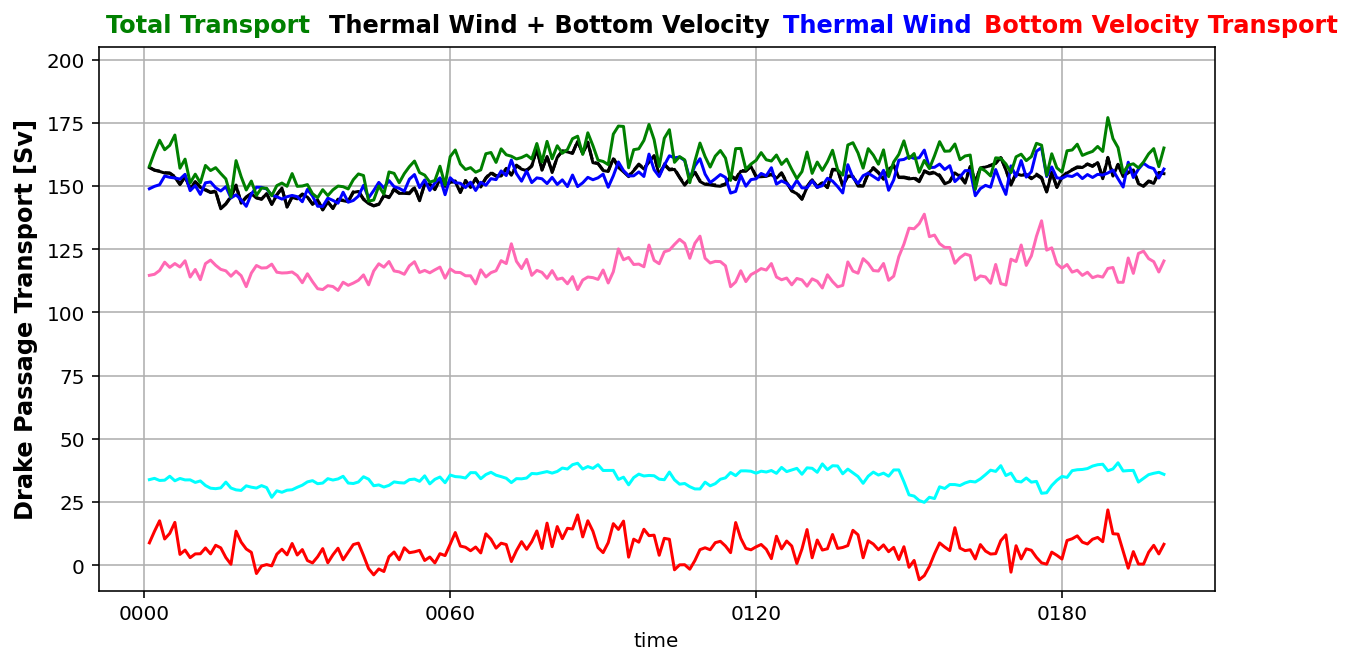

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_210_annual_mean.plot(color='k',linestyle='--')
Total_UMO_210_annual_mean.plot(color='k')
BVT_210_annual_mean.plot(color='red')
TWT_210_annual_mean.plot(color='blue')
SUM_TWT_BVT_210_annual_mean.plot(color='green')

TWT_210_temp_annual_mean.plot(color='hotpink')
TWT_210_salt_annual_mean.plot(color='cyan')


ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [ ]:
### Compute all transports
TWT_170 = compute_thermal_wind(static_sliced_om4p25,odiv_170,grid_sliced_p25)
TWT_170_temp = compute_thermal_wind_temp(static_sliced_om4p25,odiv_170,grid_sliced_p25)
TWT_170_salt = compute_thermal_wind_salinity(static_sliced_om4p25,odiv_170,grid_sliced_p25)

BVT_170 = compute_bottom_velocity_transport(static_om4p25,odiv_170.uo,odiv_170,grid_full_p25)
SUM_TWT_BVT_170 = BVT_170[1] + TWT_170[1]
Total_UO_170 = compute_transport_from_velocity(static_om4p25,odiv_170.uo,odiv_170,grid_full_p25).squeeze()
Total_UO_SV_170 = Total_UO_170.sum(dim=['yh','z_l'])/10**6
Total_UMO_170 = odiv_170.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_170_upper1000 = odiv_170.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035

### Annual Means

## Thermal Wind Components:
TWT_170_annual_mean = annual_mean(TWT_170[1])
TWT_170_upper1000_annual_mean = annual_mean(TWT_170[2])
TWT_170_below1000_annual_mean = annual_mean(TWT_170[3])

TWT_170_temp_annual_mean = annual_mean(TWT_170_temp[1])
TWT_170_upper1000_temp_annual_mean = annual_mean(TWT_170_temp[2])
TWT_170_below1000_temp_annual_mean = annual_mean(TWT_170_temp[3])

TWT_170_salt_annual_mean = annual_mean(TWT_170_salt[1])
TWT_170_upper1000_salt_annual_mean = annual_mean(TWT_170_salt[2])
TWT_170_below1000_salt_annual_mean = annual_mean(TWT_170_salt[3])

BVT_170_annual_mean = annual_mean(BVT_170[1])
SUM_TWT_BVT_170_annual_mean = annual_mean(SUM_TWT_BVT_170)
Total_UO_SV_170_annual_mean = annual_mean(Total_UO_SV_170)
Total_UMO_170_annual_mean = annual_mean(Total_UMO_170)
Total_UMO_170_upper1000_annual_mean = annual_mean(Total_UMO_170_upper1000)

Text(0.5, 1.0, '')

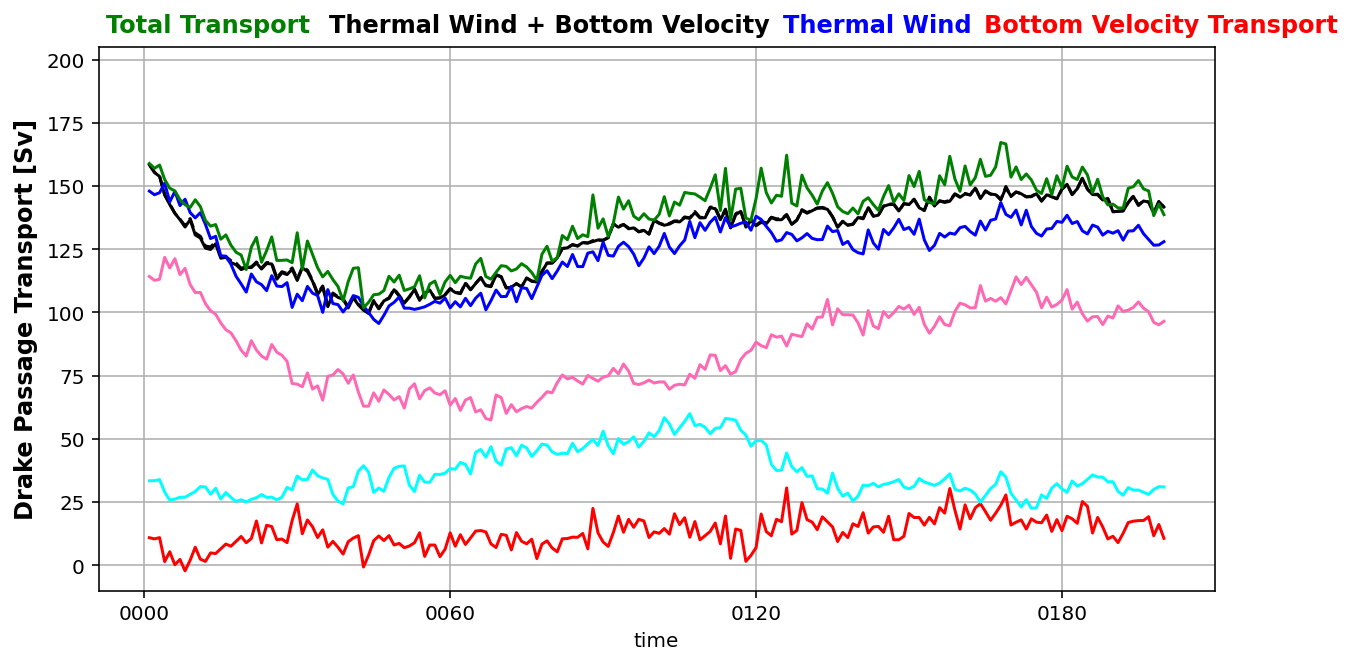

In [37]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_170_annual_mean.plot(color='k',linestyle='--')
Total_UMO_170_annual_mean.plot(color='k')
BVT_170_annual_mean.plot(color='red')
TWT_170_annual_mean.plot(color='blue')
SUM_TWT_BVT_170_annual_mean.plot(color='green')

TWT_170_temp_annual_mean.plot(color='hotpink')
TWT_170_salt_annual_mean.plot(color='cyan')


ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [15]:
### Compute all transports
TWT_cmip6 = compute_thermal_wind(static_sliced_om4p25,cmip6_cm4,grid_sliced_p25)
TWT_cmip6_temp = compute_thermal_wind_temp(static_sliced_om4p25,cmip6_cm4,grid_sliced_p25)
TWT_cmip6_salt = compute_thermal_wind_salinity(static_sliced_om4p25,cmip6_cm4,grid_sliced_p25)

BVT_cmip6 = compute_bottom_velocity_transport(static_om4p25,cmip6_cm4.uo,cmip6_cm4,grid_full_p25)
SUM_TWT_BVT_cmip6 = BVT_cmip6[1] + TWT_cmip6[1]
Total_UO_cmip6 = compute_transport_from_velocity(static_om4p25,cmip6_cm4.uo,cmip6_cm4,grid_full_p25).squeeze()
Total_UO_SV_cmip6 = Total_UO_cmip6.sum(dim=['yh','z_l'])/10**6
Total_UMO_cmip6 = cmip6_cm4.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_cmip6_upper1000 = cmip6_cm4.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_cmip6_annual_mean = annual_mean(TWT_cmip6[1])
TWT_cmip6_upper1000_annual_mean = annual_mean(TWT_cmip6[2])
TWT_cmip6_below1000_annual_mean = annual_mean(TWT_cmip6[3])

TWT_cmip6_temp_annual_mean = annual_mean(TWT_cmip6_temp[1])
TWT_cmip6_upper1000_temp_annual_mean = annual_mean(TWT_cmip6_temp[2])
TWT_cmip6_below1000_temp_annual_mean = annual_mean(TWT_cmip6_temp[3])

TWT_cmip6_salt_annual_mean = annual_mean(TWT_cmip6_salt[1])
TWT_cmip6_upper1000_salt_annual_mean = annual_mean(TWT_cmip6_salt[2])
TWT_cmip6_below1000_salt_annual_mean = annual_mean(TWT_cmip6_salt[3])

BVT_cmip6_annual_mean = annual_mean(BVT_cmip6[1])
SUM_TWT_BVT_cmip6_annual_mean = annual_mean(SUM_TWT_BVT_cmip6)
Total_UO_SV_cmip6_annual_mean = annual_mean(Total_UO_SV_cmip6)
Total_UMO_cmip6_annual_mean = annual_mean(Total_UMO_cmip6)
Total_UMO_cmip6_upper1000_annual_mean = annual_mean(Total_UMO_cmip6_upper1000)

Text(0.5, 1.0, '')

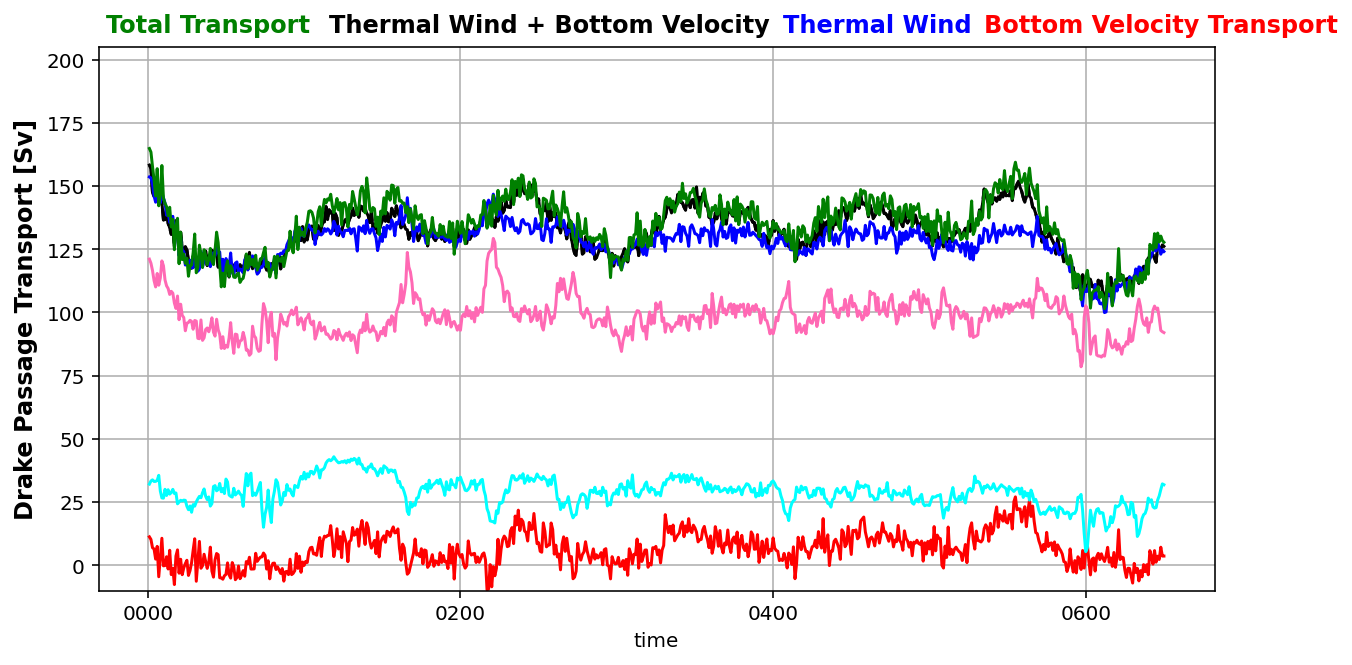

In [25]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_cmip6_annual_mean.plot(color='k',linestyle='--')
Total_UMO_cmip6_annual_mean.plot(color='k')
BVT_cmip6_annual_mean.plot(color='red')
TWT_cmip6_annual_mean.plot(color='blue')
SUM_TWT_BVT_cmip6_annual_mean.plot(color='green')

TWT_cmip6_temp_annual_mean.plot(color='hotpink')
TWT_cmip6_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [14]:
### Compute all transports
TWT_183_184 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_183_184,odiv_183_184,grid_sliced_p125)
TWT_183_184_temp = compute_thermal_wind_temp(static_sliced_om4p125,odiv_183_184,grid_sliced_p125)
TWT_183_184_salt = compute_thermal_wind_salinity(static_sliced_om4p125,odiv_183_184,grid_sliced_p125)

BVT_183_184 = compute_bottom_velocity_transport(static_om4p125,odiv_183_184.uo,odiv_183_184,grid_full_p125)
SUM_TWT_BVT_183_184 = BVT_183_184[1] + TWT_183_184[1]
Total_UO_183_184 = compute_transport_from_velocity(static_om4p125,odiv_183_184.uo,odiv_183_184,grid_full_p125).squeeze()
Total_UO_SV_183_184 = Total_UO_183_184.sum(dim=['yh','z_l'])/10**6
Total_UMO_183_184 = odiv_183_184.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_183_184_upper1000 = odiv_183_184.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035


### Annual Means
TWT_183_184_annual_mean = annual_mean(TWT_183_184[1])
TWT_183_184_upper1000_annual_mean = annual_mean(TWT_183_184[2])
TWT_183_184_below1000_annual_mean = annual_mean(TWT_183_184[3])

TWT_183_184_temp_annual_mean = annual_mean(TWT_183_184_temp[1])
TWT_183_184_upper1000_temp_annual_mean = annual_mean(TWT_183_184_temp[2])
TWT_183_184_below1000_temp_annual_mean = annual_mean(TWT_183_184_temp[3])

TWT_183_184_salt_annual_mean = annual_mean(TWT_183_184_salt[1])
TWT_183_184_upper1000_salt_annual_mean = annual_mean(TWT_183_184_salt[2])
TWT_183_184_below1000_salt_annual_mean = annual_mean(TWT_183_184_salt[3])


BVT_183_184_annual_mean = annual_mean(BVT_183_184[1])
SUM_TWT_BVT_183_184_annual_mean = annual_mean(SUM_TWT_BVT_183_184)
Total_UO_SV_183_184_annual_mean = annual_mean(Total_UO_SV_183_184)
Total_UMO_183_184_annual_mean = annual_mean(Total_UMO_183_184)
Total_UMO_183_184_upper1000_annual_mean = annual_mean(Total_UMO_183_184_upper1000)

Text(0.5, 1.0, 'Odiv-183/4')

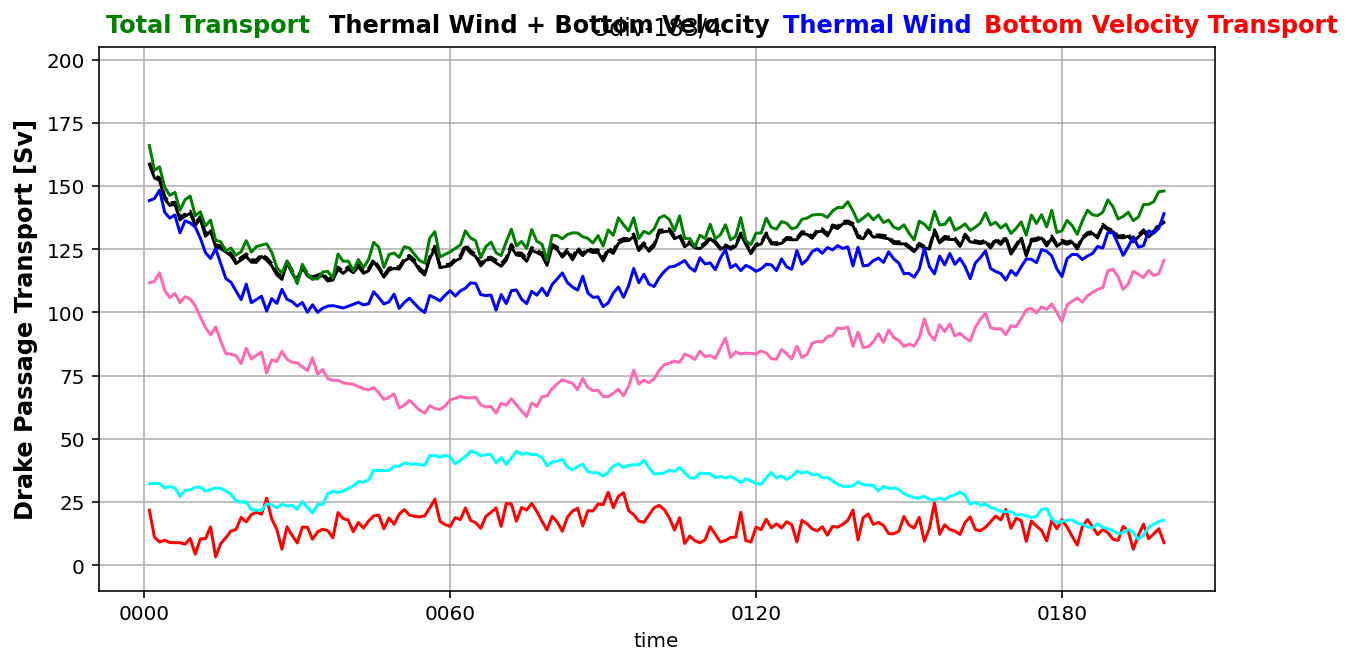

In [48]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_183_184_annual_mean.plot(color='k',linestyle='--')
Total_UMO_183_184_annual_mean.plot(color='k')
BVT_183_184_annual_mean.plot(color='red')
TWT_183_184_annual_mean.plot(color='blue')
SUM_TWT_BVT_183_184_annual_mean.plot(color='green')

TWT_183_184_temp_annual_mean.plot(color='hotpink')
TWT_183_184_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('Odiv-183/4')

### Compute Thermal Wind Transport (TWT) and Bottom Velocity Transport for Odiv-191

In [15]:
### Compute all transports
TWT_191 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_191,odiv_191,grid_sliced_p125)
TWT_191_temp = compute_thermal_wind_temp(static_sliced_om4p125,odiv_191,grid_sliced_p125)
TWT_191_salt = compute_thermal_wind_salinity(static_sliced_om4p125,odiv_191,grid_sliced_p125)

BVT_191 = compute_bottom_velocity_transport(static_om4p125,odiv_191.uo,odiv_191,grid_full_p125)
SUM_TWT_BVT_191 = BVT_191[1] + TWT_191[1]
Total_UO_191 = compute_transport_from_velocity(static_om4p125,odiv_191.uo,odiv_191,grid_full_p125).squeeze()
Total_UO_SV_191 = Total_UO_191.sum(dim=['yh','z_l'])/10**6
Total_UMO_191 = odiv_191.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_191_upper1000 = odiv_191.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_191_annual_mean = annual_mean(TWT_191[1])
TWT_191_upper1000_annual_mean = annual_mean(TWT_191[2])
TWT_191_below1000_annual_mean = annual_mean(TWT_191[3])

TWT_191_temp_annual_mean = annual_mean(TWT_191_temp[1])
TWT_191_upper1000_temp_annual_mean = annual_mean(TWT_191_temp[2])
TWT_191_below1000_temp_annual_mean = annual_mean(TWT_191_temp[3])

TWT_191_salt_annual_mean = annual_mean(TWT_191_salt[1])
TWT_191_upper1000_salt_annual_mean = annual_mean(TWT_191_salt[2])
TWT_191_below1000_salt_annual_mean = annual_mean(TWT_191_salt[3])

BVT_191_annual_mean = annual_mean(BVT_191[1])
SUM_TWT_BVT_191_annual_mean = annual_mean(SUM_TWT_BVT_191)
Total_UO_SV_191_annual_mean = annual_mean(Total_UO_SV_191)
Total_UMO_191_annual_mean = annual_mean(Total_UMO_191)
Total_UMO_191_upper1000_annual_mean = annual_mean(Total_UMO_191_upper1000)

Text(0.5, 1.0, '')

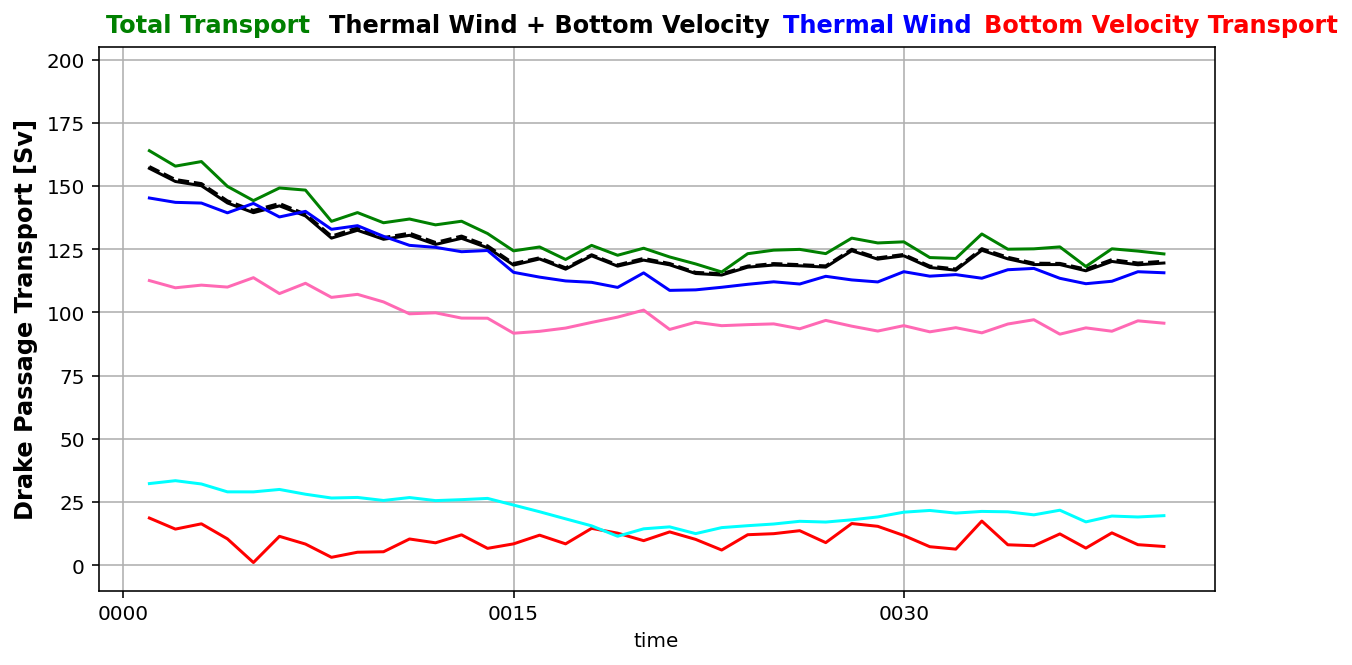

In [50]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_191_annual_mean.plot(color='k',linestyle='--')
Total_UMO_191_annual_mean.plot(color='k')
BVT_191_annual_mean.plot(color='red')
TWT_191_annual_mean.plot(color='blue')
SUM_TWT_BVT_191_annual_mean.plot(color='green')

TWT_191_temp_annual_mean.plot(color='hotpink')
TWT_191_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [16]:
### Compute all transports
TWT_200 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_200,odiv_200,grid_sliced_p125)
TWT_200_temp = compute_thermal_wind_temp(static_sliced_om4p125,odiv_200,grid_sliced_p125)
TWT_200_salt = compute_thermal_wind_salinity(static_sliced_om4p125,odiv_200,grid_sliced_p125)

BVT_200 = compute_bottom_velocity_transport(static_om4p125,odiv_200.uo,odiv_200,grid_full_p125)
SUM_TWT_BVT_200 = BVT_200[1] + TWT_200[1]
Total_UO_200 = compute_transport_from_velocity(static_om4p125,odiv_200.uo,odiv_200,grid_full_p125).squeeze()
Total_UO_SV_200 = Total_UO_200.sum(dim=['yh','z_l'])/10**6
Total_UMO_200 = odiv_200.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_200_upper1000 = odiv_200.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_200_annual_mean = annual_mean(TWT_200[1])
TWT_200_upper1000_annual_mean = annual_mean(TWT_200[2])
TWT_200_below1000_annual_mean = annual_mean(TWT_200[3])

TWT_200_temp_annual_mean = annual_mean(TWT_200_temp[1])
TWT_200_upper1000_temp_annual_mean = annual_mean(TWT_200_temp[2])
TWT_200_below1000_temp_annual_mean = annual_mean(TWT_200_temp[3])

TWT_200_salt_annual_mean = annual_mean(TWT_200_salt[1])
TWT_200_upper1000_salt_annual_mean = annual_mean(TWT_200_salt[2])
TWT_200_below1000_salt_annual_mean = annual_mean(TWT_200_salt[3])

BVT_200_annual_mean = annual_mean(BVT_200[1])
SUM_TWT_BVT_200_annual_mean = annual_mean(SUM_TWT_BVT_200)
Total_UO_SV_200_annual_mean = annual_mean(Total_UO_SV_200)
Total_UMO_200_annual_mean = annual_mean(Total_UMO_200)
Total_UMO_200_upper1000_annual_mean = annual_mean(Total_UMO_200_upper1000)

Text(0.5, 1.0, '')

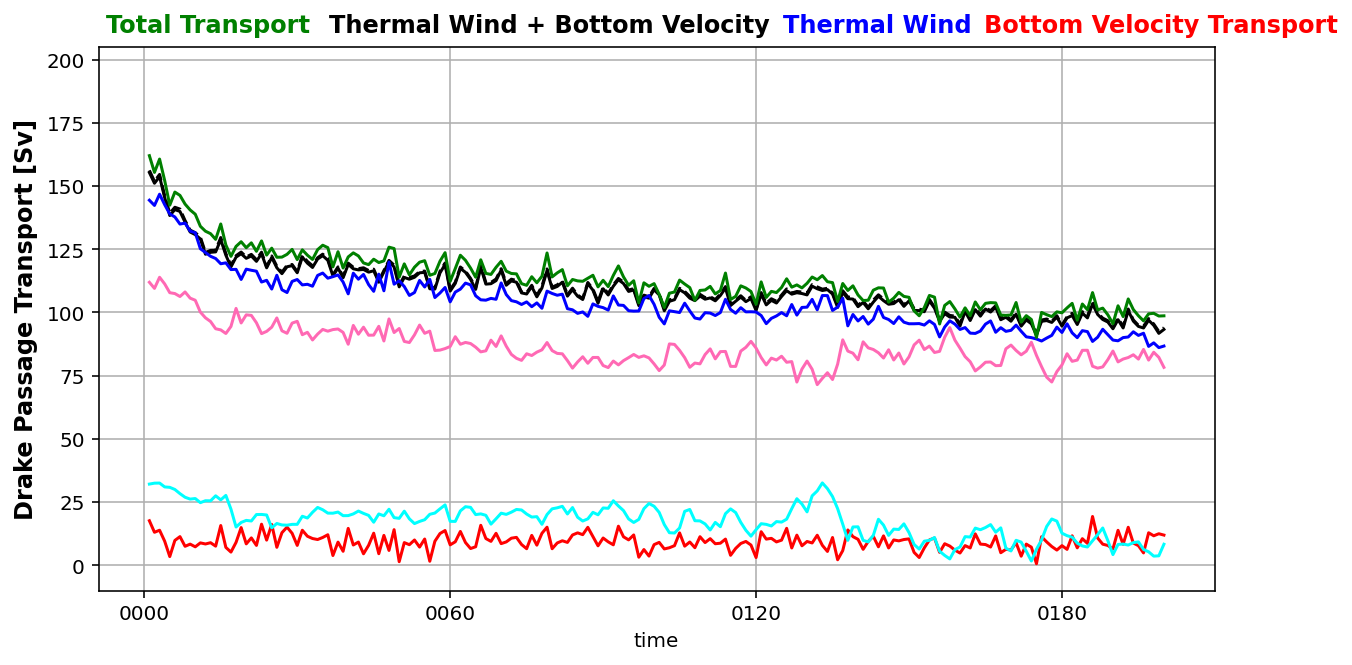

In [52]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_200_annual_mean.plot(color='k',linestyle='--')
Total_UMO_200_annual_mean.plot(color='k')
BVT_200_annual_mean.plot(color='red')
TWT_200_annual_mean.plot(color='blue')
SUM_TWT_BVT_200_annual_mean.plot(color='green')

TWT_200_temp_annual_mean.plot(color='hotpink')
TWT_200_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [17]:
### Compute all transports
TWT_206 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_206,odiv_206,grid_sliced_p125)
TWT_206_temp = compute_thermal_wind_temp(static_sliced_om4p125,odiv_206,grid_sliced_p125)
TWT_206_salt = compute_thermal_wind_salinity(static_sliced_om4p125,odiv_206,grid_sliced_p125)


BVT_206 = compute_bottom_velocity_transport(static_om4p125,odiv_206.uo,odiv_206,grid_full_p125)
SUM_TWT_BVT_206 = BVT_206[1] + TWT_206[1]
Total_UO_206 = compute_transport_from_velocity(static_om4p125,odiv_206.uo,odiv_206,grid_full_p125).squeeze()
Total_UO_SV_206 = Total_UO_206.sum(dim=['yh','z_l'])/10**6
Total_UMO_206 = odiv_206.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_206_upper1000 = odiv_206.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035


### Annual Means
TWT_206_annual_mean = annual_mean(TWT_206[1])
TWT_206_upper1000_annual_mean = annual_mean(TWT_206[2])
TWT_206_below1000_annual_mean = annual_mean(TWT_206[3])

TWT_206_temp_annual_mean = annual_mean(TWT_206_temp[1])
TWT_206_upper1000_temp_annual_mean = annual_mean(TWT_206_temp[2])
TWT_206_below1000_temp_annual_mean = annual_mean(TWT_206_temp[3])

TWT_206_salt_annual_mean = annual_mean(TWT_206_salt[1])
TWT_206_upper1000_salt_annual_mean = annual_mean(TWT_206_salt[2])
TWT_206_below1000_salt_annual_mean = annual_mean(TWT_206_salt[3])

BVT_206_annual_mean = annual_mean(BVT_206[1])
SUM_TWT_BVT_206_annual_mean = annual_mean(SUM_TWT_BVT_206)
Total_UO_SV_206_annual_mean = annual_mean(Total_UO_SV_206)
Total_UMO_206_annual_mean = annual_mean(Total_UMO_206)
Total_UMO_206_upper1000_annual_mean = annual_mean(Total_UMO_206_upper1000)

Text(0.5, 1.0, '')

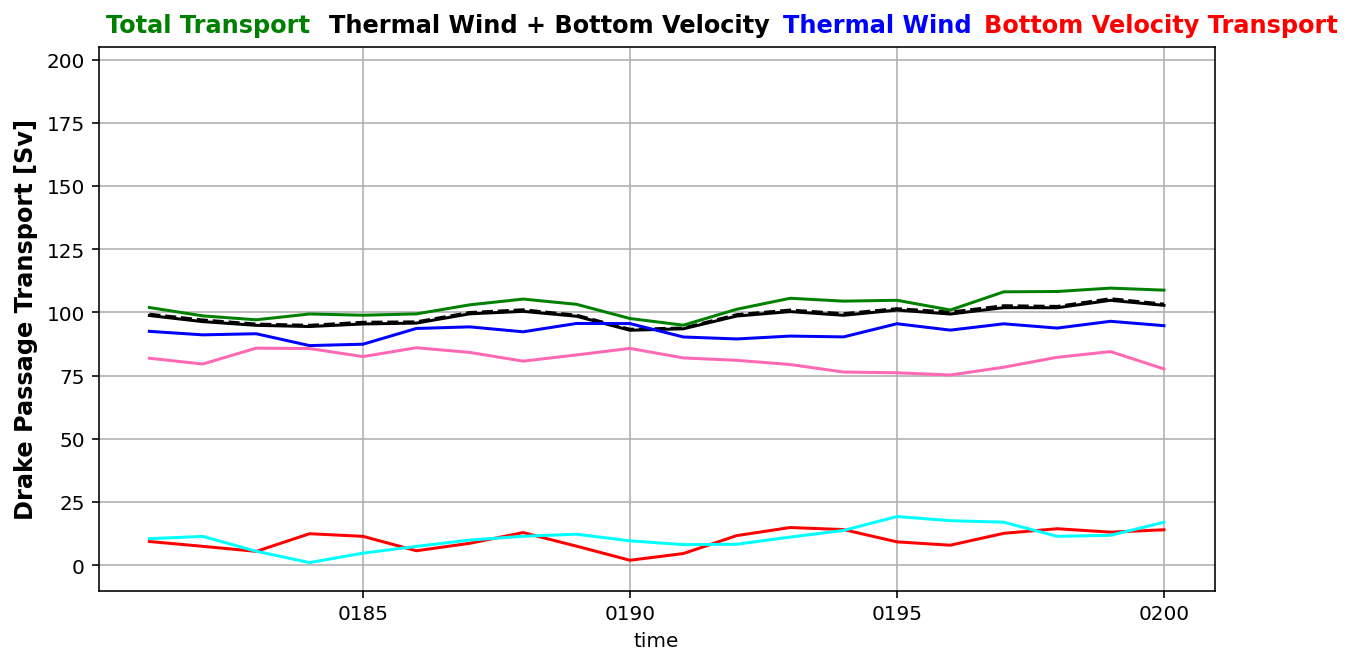

In [54]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_206_annual_mean.plot(color='k',linestyle='--')
Total_UMO_206_annual_mean.plot(color='k')
BVT_206_annual_mean.plot(color='red')
TWT_206_annual_mean.plot(color='blue')
SUM_TWT_BVT_206_annual_mean.plot(color='green')

TWT_206_temp_annual_mean.plot(color='hotpink')
TWT_206_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [18]:
### Compute all transports
TWT_207 = compute_thermal_wind(static_sliced_om4p125,rho_odiv_207,odiv_207,grid_sliced_p125)
TWT_207_temp = compute_thermal_wind_temp(static_sliced_om4p125,odiv_207,grid_sliced_p125)
TWT_207_salt = compute_thermal_wind_salinity(static_sliced_om4p125,odiv_207,grid_sliced_p125)

BVT_207 = compute_bottom_velocity_transport(static_om4p125,odiv_207.uo,odiv_207,grid_full_p125)
SUM_TWT_BVT_207 = BVT_207[1] + TWT_207[1]
Total_UO_207 = compute_transport_from_velocity(static_om4p125,odiv_207.uo,odiv_207,grid_full_p125).squeeze()
Total_UO_SV_207 = Total_UO_207.sum(dim=['yh','z_l'])/10**6
Total_UMO_207 = odiv_207.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_207_upper1000 = odiv_207.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_207_annual_mean = annual_mean(TWT_207[1])
TWT_207_upper1000_annual_mean = annual_mean(TWT_207[2])
TWT_207_below1000_annual_mean = annual_mean(TWT_207[3])

TWT_207_temp_annual_mean = annual_mean(TWT_207_temp[1])
TWT_207_upper1000_temp_annual_mean = annual_mean(TWT_207_temp[2])
TWT_207_below1000_temp_annual_mean = annual_mean(TWT_207_temp[3])

TWT_207_salt_annual_mean = annual_mean(TWT_207_salt[1])
TWT_207_upper1000_salt_annual_mean = annual_mean(TWT_207_salt[2])
TWT_207_below1000_salt_annual_mean = annual_mean(TWT_207_salt[3])

BVT_207_annual_mean = annual_mean(BVT_207[1])
SUM_TWT_BVT_207_annual_mean = annual_mean(SUM_TWT_BVT_207)
Total_UO_SV_207_annual_mean = annual_mean(Total_UO_SV_207)
Total_UMO_207_annual_mean = annual_mean(Total_UMO_207)
Total_UMO_207_upper1000_annual_mean = annual_mean(Total_UMO_207_upper1000)

Text(0.5, 1.0, '')

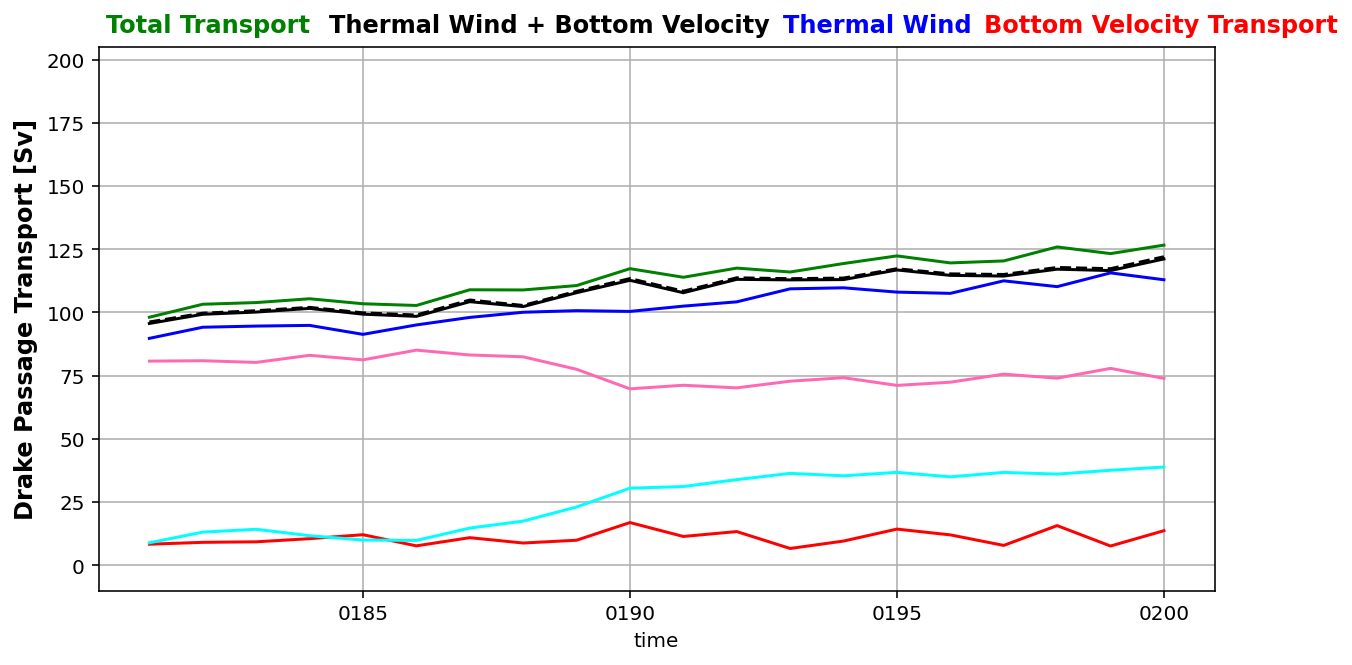

In [56]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_207_annual_mean.plot(color='k',linestyle='--')
Total_UMO_207_annual_mean.plot(color='k')
BVT_207_annual_mean.plot(color='red')
TWT_207_annual_mean.plot(color='blue')
SUM_TWT_BVT_207_annual_mean.plot(color='green')

TWT_207_temp_annual_mean.plot(color='hotpink')
TWT_207_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [16]:
### Compute all transports
TWT_209 = compute_thermal_wind(static_sliced_om4p125,odiv_209,grid_sliced_p125)
TWT_209_temp = compute_thermal_wind_temp(static_sliced_om4p125,odiv_209,grid_sliced_p125)
TWT_209_salt = compute_thermal_wind_salinity(static_sliced_om4p125,odiv_209,grid_sliced_p125)

BVT_209 = compute_bottom_velocity_transport(static_om4p125,odiv_209.uo,odiv_209,grid_full_p125)
SUM_TWT_BVT_209 = BVT_209[1] + TWT_209[1]
Total_UO_209 = compute_transport_from_velocity(static_om4p125,odiv_209.uo,odiv_209,grid_full_p125).squeeze()
Total_UO_SV_209 = Total_UO_209.sum(dim=['yh','z_l'])/10**6
Total_UMO_209 = odiv_209.umo.sum(dim=['yh','z_l'])/10**6/1035
Total_UMO_209_upper1000 = odiv_209.umo.sel(z_l=slice(0,1000)).sum(dim=['yh','z_l'])/10**6/1035

### Annual Means
TWT_209_annual_mean = annual_mean(TWT_209[1])
TWT_209_upper1000_annual_mean = annual_mean(TWT_209[2])
TWT_209_below1000_annual_mean = annual_mean(TWT_209[3])

TWT_209_temp_annual_mean = annual_mean(TWT_209_temp[1])
TWT_209_upper1000_temp_annual_mean = annual_mean(TWT_209_temp[2])
TWT_209_below1000_temp_annual_mean = annual_mean(TWT_209_temp[3])

TWT_209_salt_annual_mean = annual_mean(TWT_209_salt[1])
TWT_209_upper1000_salt_annual_mean = annual_mean(TWT_209_salt[2])
TWT_209_below1000_salt_annual_mean = annual_mean(TWT_209_salt[3])

BVT_209_annual_mean = annual_mean(BVT_209[1])
SUM_TWT_BVT_209_annual_mean = annual_mean(SUM_TWT_BVT_209)
Total_UO_SV_209_annual_mean = annual_mean(Total_UO_SV_209)
Total_UMO_209_annual_mean = annual_mean(Total_UMO_209)
Total_UMO_209_upper1000_annual_mean = annual_mean(Total_UMO_209_upper1000)

Text(0.5, 1.0, '')

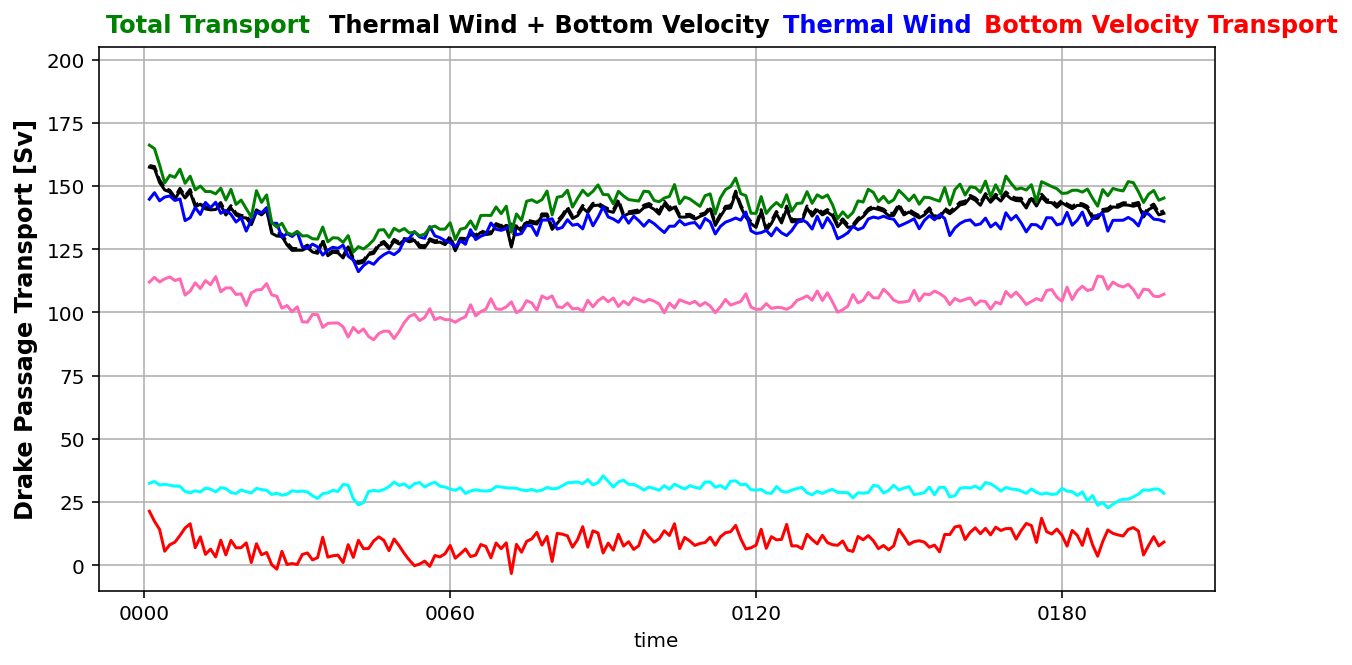

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_209_annual_mean.plot(color='k',linestyle='--')
Total_UMO_209_annual_mean.plot(color='k')
BVT_209_annual_mean.plot(color='red')
TWT_209_annual_mean.plot(color='blue')
SUM_TWT_BVT_209_annual_mean.plot(color='green')

TWT_209_temp_annual_mean.plot(color='hotpink')
TWT_209_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

Total_UO_SV_210_annual_mean.plot(color='k',linestyle='--')
Total_UMO_210_annual_mean.plot(color='k')
BVT_210_annual_mean.plot(color='red')
TWT_210_annual_mean.plot(color='blue')
SUM_TWT_BVT_210_annual_mean.plot(color='green')

TWT_210_temp_annual_mean.plot(color='hotpink')
TWT_210_salt_annual_mean.plot(color='cyan')

ax.set_ylabel('Drake Passage Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,205)

fig.text(0.13,0.90,'Total Transport',fontsize=12,color='green',fontweight='bold')
fig.text(0.285,0.90,'Thermal Wind + Bottom Velocity',fontsize=12,color='black',fontweight='bold')
fig.text(0.60,0.90,'Thermal Wind',fontsize=12,color='blue',fontweight='bold')
fig.text(0.74,0.90,'Bottom Velocity Transport',fontsize=12,color='red',fontweight='bold')

plt.title('')

### All configurations on same plot 

Text(0.5, 1.0, '')

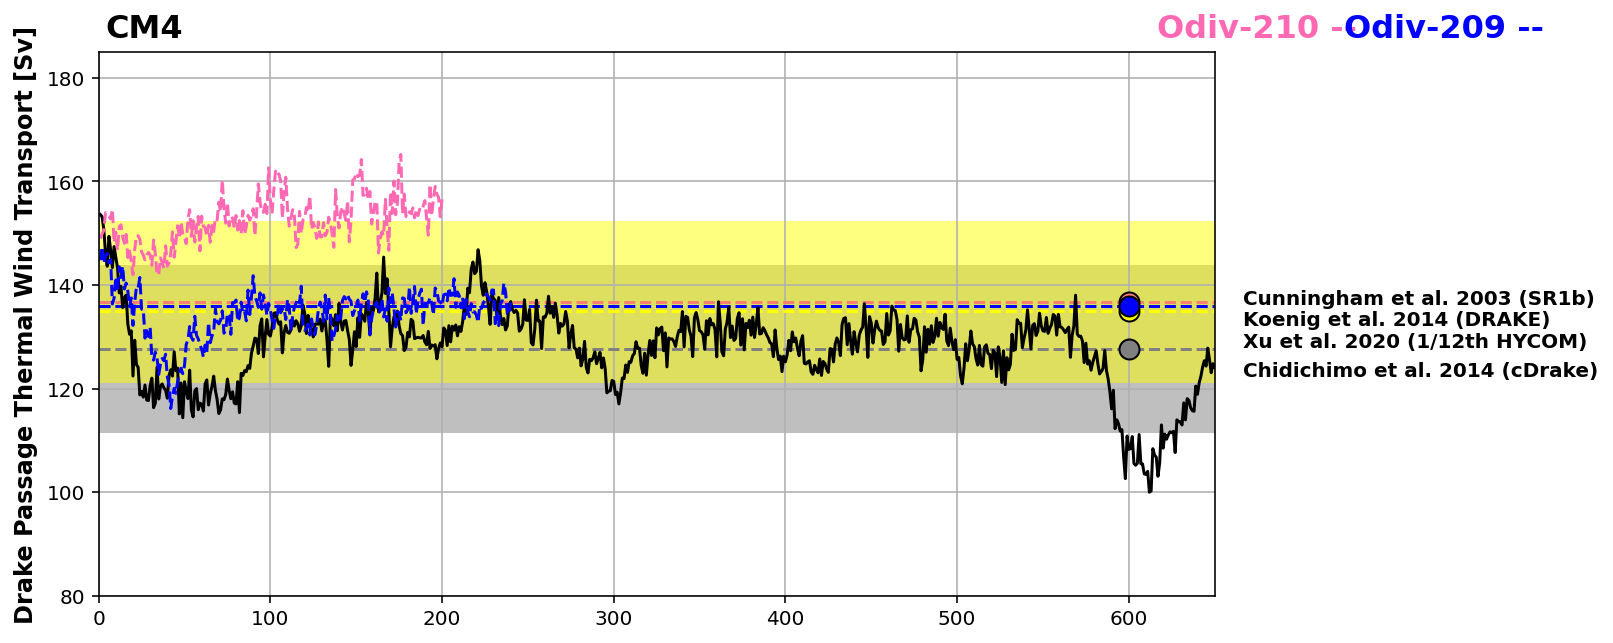

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

x_end = 600

x_all = (0,650)
y1_SR1b = (121.1)  
y2_SR1b = (152.3)
y3_SR1b = (136.7)  ## Value of 136.7 +/- 7.8 Sv (standard dev) from Cunningham et al. 2003

y_cDrake = (111.5)
y1_cDrake = (143.9)
y2_cDrake = (127.7)  ## Value of 127.7 +/- 8.1 Sv (standard dev) from Chidichimo et al. 2014

y_Xu = (135.0)
y_DRAKE = (136)

ax.fill_between(x_all,y_cDrake,y1_cDrake,facecolor='grey',alpha=0.5)
ax.fill_between(x_all,y1_SR1b,y2_SR1b,facecolor='yellow',alpha=0.5)

plt.axhline(y=127.7,linestyle='--',color='grey')
plt.axhline(y=136.7,linestyle='--',color='salmon')
plt.axhline(y=135,linestyle='--',color='yellow')
plt.axhline(y=136,linestyle='--',color='blue')

plt.plot(TWT_cmip6_annual_mean.time.dt.year,TWT_cmip6_annual_mean.values,color='black')
#plt.plot(TWT_170_annual_mean.time.dt.year,TWT_170_annual_mean.values,color='green')
#plt.plot(TWT_183_184_annual_mean.time.dt.year,TWT_183_184_annual_mean.values,color='blue')
#plt.plot(TWT_191_annual_mean.time.dt.year,TWT_191_annual_mean.values,color='red')
#plt.plot(TWT_200_annual_mean.time.dt.year,TWT_200_annual_mean.values,color='cyan')
#plt.plot(TWT_206_annual_mean.time.dt.year,TWT_206_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_annual_mean.time.dt.year,TWT_207_annual_mean.values,color='orange')
plt.plot(TWT_209_annual_mean.time.dt.year,TWT_209_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_annual_mean.time.dt.year,TWT_210_annual_mean.values,color='hotpink',linestyle='--')

ax.set_ylabel('Drake Passage Thermal Wind Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(80,185)
plt.xlim(0,650)

plt.plot(x_end,y2_cDrake,marker='o',markersize=10,markerfacecolor='grey',markeredgecolor='k')
plt.plot(x_end,y3_SR1b,marker='o',markersize=10,markerfacecolor='salmon',markeredgecolor='k')
plt.plot(x_end,y_Xu,marker='o',markersize=10,markerfacecolor='yellow',markeredgecolor='k')
plt.plot(x_end,y_DRAKE,marker='o',markersize=10,markerfacecolor='blue',markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

fig.text(0.92,0.43,'Chidichimo et al. 2014 (cDrake)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.53,'Cunningham et al. 2003 (SR1b)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.50,'Koenig et al. 2014 (DRAKE)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.47,'Xu et al. 2020 (1/12th HYCOM)',fontsize=10,color='black',fontweight='bold')

plt.title('')

Text(0.5, 1.0, '')

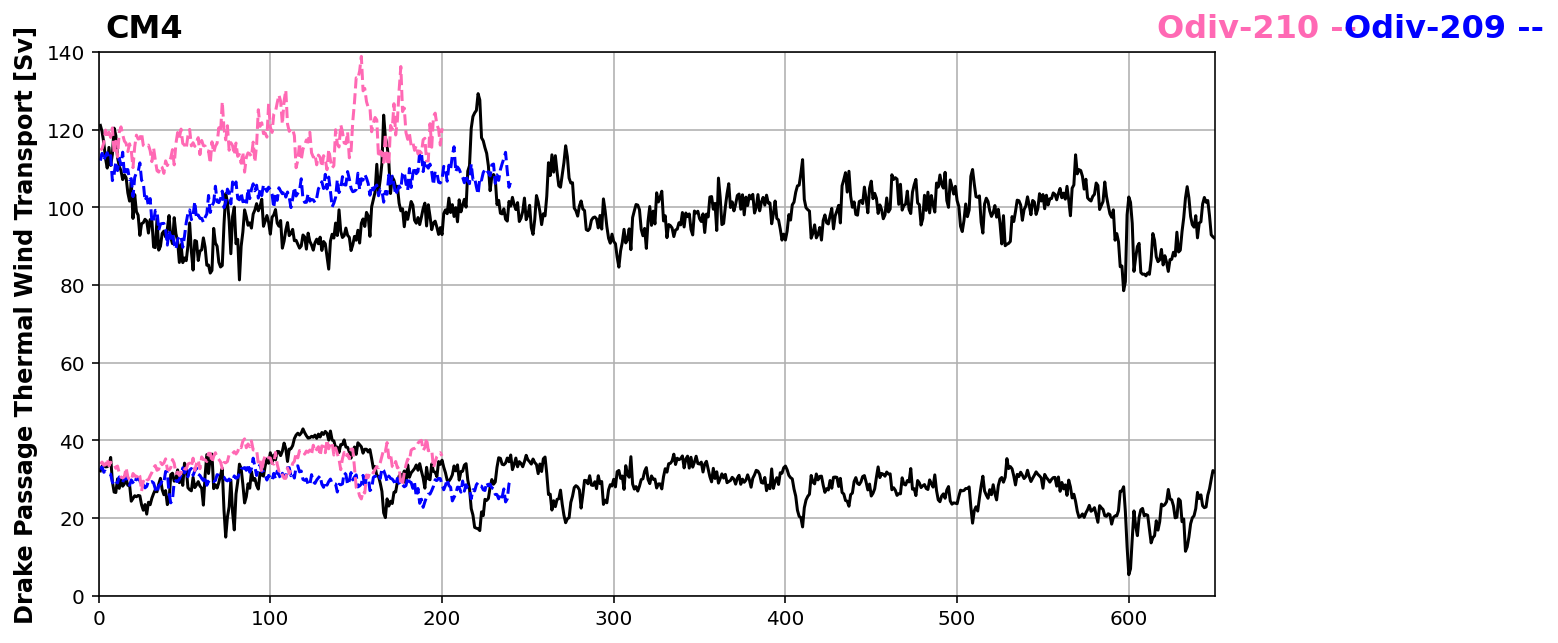

In [18]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(TWT_cmip6_temp_annual_mean.time.dt.year,TWT_cmip6_temp_annual_mean.values,color='black')
#plt.plot(TWT_170_temp_annual_mean.time.dt.year,TWT_170_temp_annual_mean.values,color='green')
#plt.plot(TWT_183_184_temp_annual_mean.time.dt.year,TWT_183_184_temp_annual_mean.values,color='blue')
#plt.plot(TWT_191_temp_annual_mean.time.dt.year,TWT_191_temp_annual_mean.values,color='red')
#plt.plot(TWT_200_temp_annual_mean.time.dt.year,TWT_200_temp_annual_mean.values,color='cyan')
#plt.plot(TWT_206_temp_annual_mean.time.dt.year,TWT_206_temp_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_temp_annual_mean.time.dt.year,TWT_207_temp_annual_mean.values,color='orange')
plt.plot(TWT_209_temp_annual_mean.time.dt.year,TWT_209_temp_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_temp_annual_mean.time.dt.year,TWT_210_temp_annual_mean.values,color='hotpink',linestyle='--')

plt.plot(TWT_cmip6_salt_annual_mean.time.dt.year,TWT_cmip6_salt_annual_mean.values,color='black')
#plt.plot(TWT_170_salt_annual_mean.time.dt.year,TWT_170_salt_annual_mean.values,color='green')
#plt.plot(TWT_183_184_salt_annual_mean.time.dt.year,TWT_183_184_salt_annual_mean.values,color='blue')
#plt.plot(TWT_191_salt_annual_mean.time.dt.year,TWT_191_salt_annual_mean.values,color='red')
#plt.plot(TWT_200_salt_annual_mean.time.dt.year,TWT_200_salt_annual_mean.values,color='cyan')
#plt.plot(TWT_206_salt_annual_mean.time.dt.year,TWT_206_salt_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_salt_annual_mean.time.dt.year,TWT_207_salt_annual_mean.values,color='orange')
plt.plot(TWT_209_salt_annual_mean.time.dt.year,TWT_209_salt_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_salt_annual_mean.time.dt.year,TWT_210_salt_annual_mean.values,color='hotpink',linestyle='--')

ax.set_ylabel('Drake Passage Thermal Wind Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(0,140)
plt.xlim(0,650)

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

plt.title('')

Text(0.99, 0.9, 'Odiv-209 --')

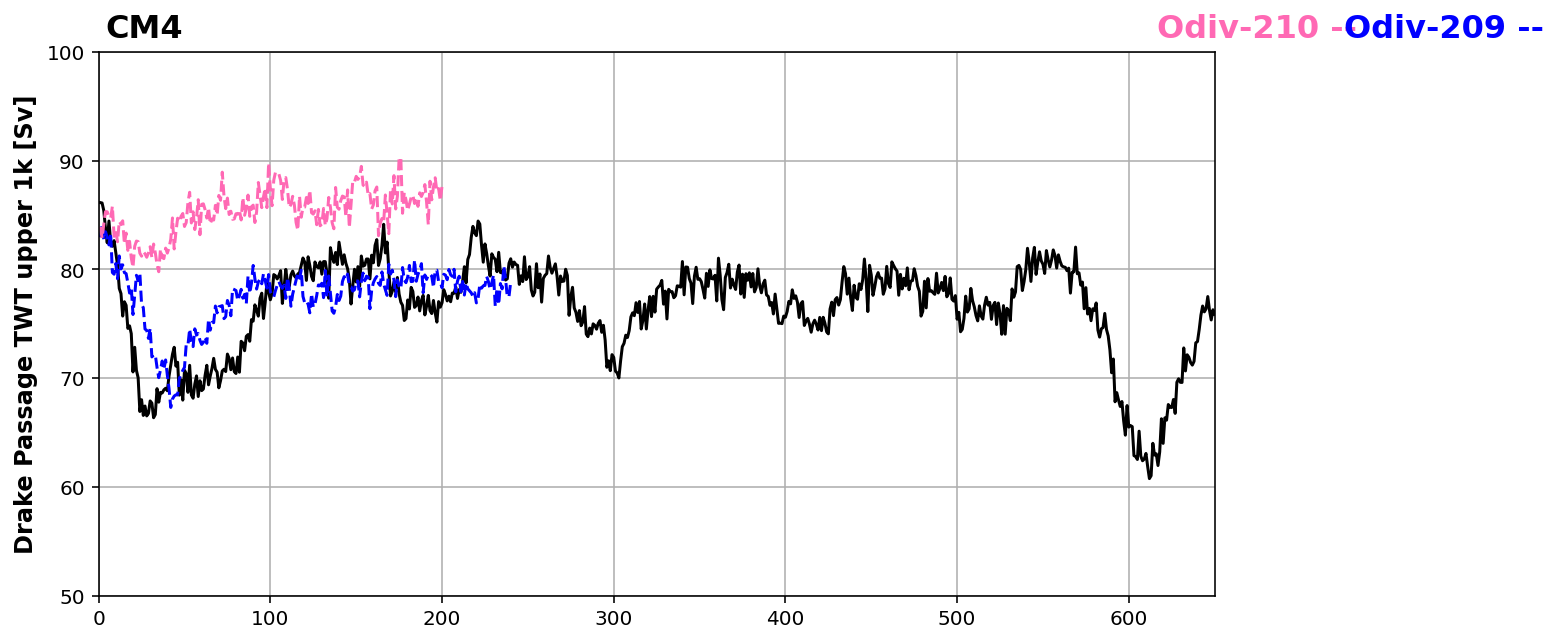

In [19]:
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(TWT_cmip6_upper1000_annual_mean.time.dt.year,TWT_cmip6_upper1000_annual_mean.values,color='black')
#plt.plot(TWT_170_upper1000_annual_mean.time.dt.year,TWT_170_upper1000_annual_mean.values,color='green')
#plt.plot(TWT_183_184_upper1000_annual_mean.time.dt.year,TWT_183_184_upper1000_annual_mean.values,color='blue')
#plt.plot(TWT_191_upper1000_annual_mean.time.dt.year,TWT_191_upper1000_annual_mean.values,color='red')
#plt.plot(TWT_200_upper1000_annual_mean.time.dt.year,TWT_200_upper1000_annual_mean.values,color='cyan')
#plt.plot(TWT_206_upper1000_annual_mean.time.dt.year,TWT_206_upper1000_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_upper1000_annual_mean.time.dt.year,TWT_207_upper1000_annual_mean.values,color='orange')
plt.plot(TWT_209_upper1000_annual_mean.time.dt.year,TWT_209_upper1000_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_upper1000_annual_mean.time.dt.year,TWT_210_upper1000_annual_mean.values,color='hotpink',linestyle='--')


ax.set_ylabel('Drake Passage TWT upper 1k [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(50,100)
plt.xlim(0,650)


fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

Text(0.99, 0.9, 'Odiv-209 --')

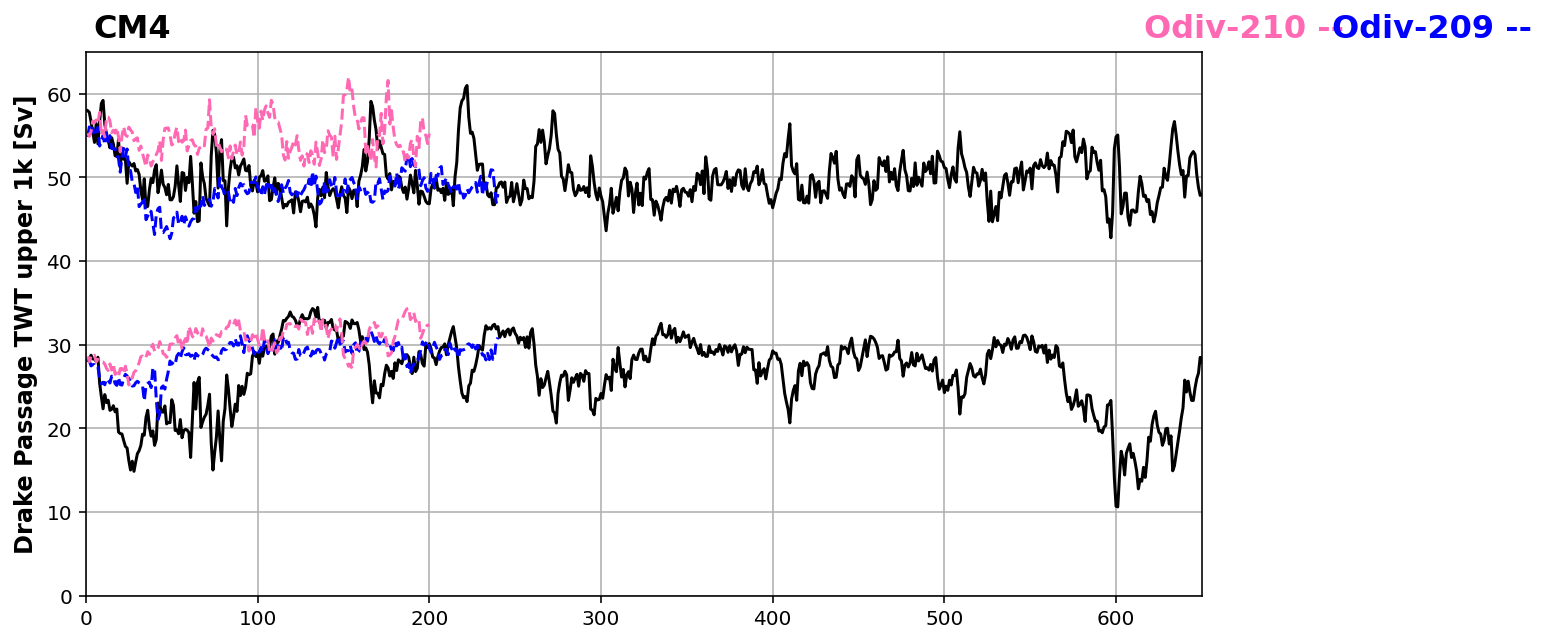

In [20]:
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(TWT_cmip6_upper1000_temp_annual_mean.time.dt.year,TWT_cmip6_upper1000_temp_annual_mean.values,color='black')
#plt.plot(TWT_170_upper1000_temp_annual_mean.time.dt.year,TWT_170_upper1000_temp_annual_mean.values,color='green')
#plt.plot(TWT_183_184_upper1000_temp_annual_mean.time.dt.year,TWT_183_184_upper1000_temp_annual_mean.values,color='blue')
#plt.plot(TWT_191_upper1000_temp_annual_mean.time.dt.year,TWT_191_upper1000_temp_annual_mean.values,color='red')
#plt.plot(TWT_200_upper1000_temp_annual_mean.time.dt.year,TWT_200_upper1000_temp_annual_mean.values,color='cyan')
#plt.plot(TWT_206_upper1000_temp_annual_mean.time.dt.year,TWT_206_upper1000_temp_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_upper1000_temp_annual_mean.time.dt.year,TWT_207_upper1000_temp_annual_mean.values,color='orange')
plt.plot(TWT_209_upper1000_temp_annual_mean.time.dt.year,TWT_209_upper1000_temp_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_upper1000_temp_annual_mean.time.dt.year,TWT_210_upper1000_temp_annual_mean.values,color='hotpink',linestyle='--')

plt.plot(TWT_cmip6_upper1000_salt_annual_mean.time.dt.year,TWT_cmip6_upper1000_salt_annual_mean.values,color='black')
#plt.plot(TWT_170_upper1000_salt_annual_mean.time.dt.year,TWT_170_upper1000_salt_annual_mean.values,color='green')
#plt.plot(TWT_183_184_upper1000_salt_annual_mean.time.dt.year,TWT_183_184_upper1000_salt_annual_mean.values,color='blue')
#plt.plot(TWT_191_upper1000_salt_annual_mean.time.dt.year,TWT_191_upper1000_salt_annual_mean.values,color='red')
#plt.plot(TWT_200_upper1000_salt_annual_mean.time.dt.year,TWT_200_upper1000_salt_annual_mean.values,color='cyan')
#plt.plot(TWT_206_upper1000_salt_annual_mean.time.dt.year,TWT_206_upper1000_salt_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_upper1000_salt_annual_mean.time.dt.year,TWT_207_upper1000_salt_annual_mean.values,color='orange')
plt.plot(TWT_209_upper1000_salt_annual_mean.time.dt.year,TWT_209_upper1000_salt_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_upper1000_salt_annual_mean.time.dt.year,TWT_210_upper1000_salt_annual_mean.values,color='hotpink',linestyle='--')


ax.set_ylabel('Drake Passage TWT upper 1k [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(0,65)
plt.xlim(0,650)


fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

Text(0.99, 0.9, 'Odiv-209 --')

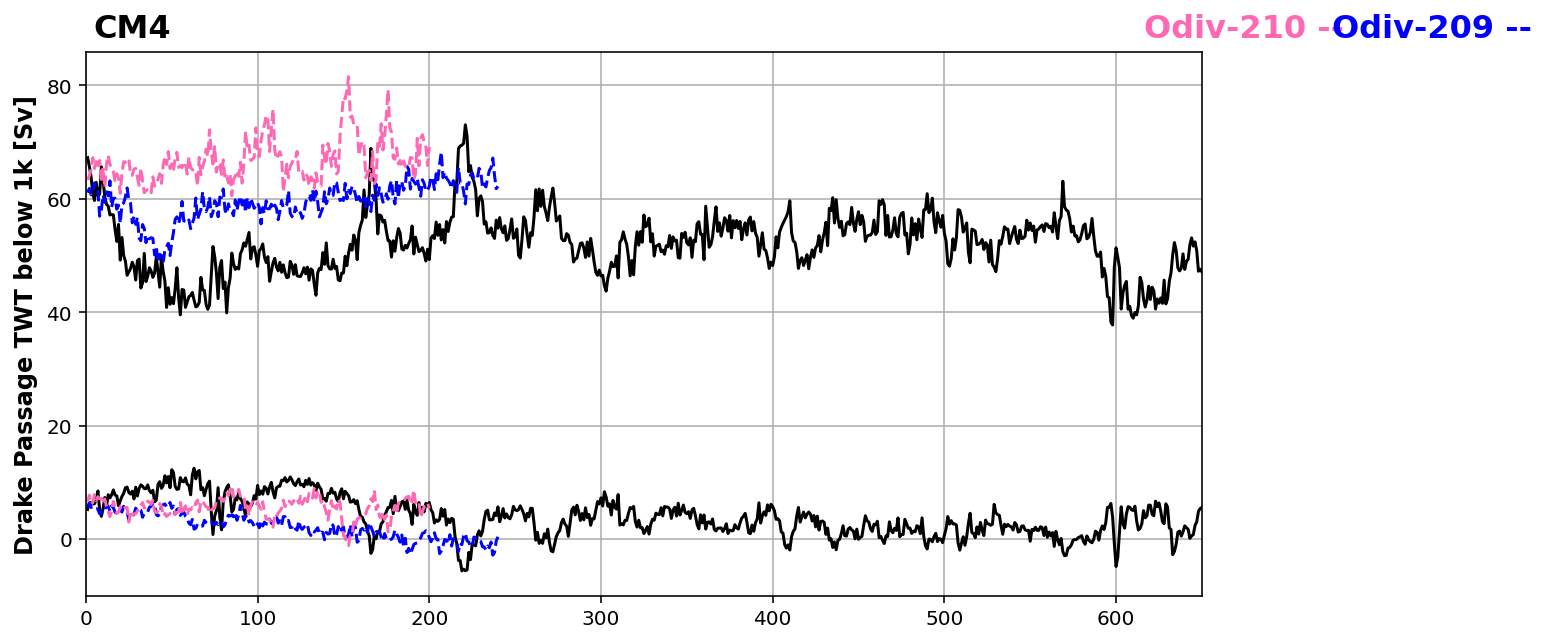

In [21]:
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(TWT_cmip6_below1000_temp_annual_mean.time.dt.year,TWT_cmip6_below1000_temp_annual_mean.values,color='black')
#plt.plot(TWT_170_below1000_temp_annual_mean.time.dt.year,TWT_170_below1000_temp_annual_mean.values,color='green')
#plt.plot(TWT_183_184_below1000_temp_annual_mean.time.dt.year,TWT_183_184_below1000_temp_annual_mean.values,color='blue')
#plt.plot(TWT_191_below1000_temp_annual_mean.time.dt.year,TWT_191_below1000_temp_annual_mean.values,color='red')
#plt.plot(TWT_200_below1000_temp_annual_mean.time.dt.year,TWT_200_below1000_temp_annual_mean.values,color='cyan')
#plt.plot(TWT_206_below1000_temp_annual_mean.time.dt.year,TWT_206_below1000_temp_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_below1000_temp_annual_mean.time.dt.year,TWT_207_below1000_temp_annual_mean.values,color='orange')
plt.plot(TWT_209_below1000_temp_annual_mean.time.dt.year,TWT_209_below1000_temp_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_below1000_temp_annual_mean.time.dt.year,TWT_210_below1000_temp_annual_mean.values,color='hotpink',linestyle='--')

plt.plot(TWT_cmip6_below1000_salt_annual_mean.time.dt.year,TWT_cmip6_below1000_salt_annual_mean.values,color='black')
#plt.plot(TWT_170_below1000_salt_annual_mean.time.dt.year,TWT_170_below1000_salt_annual_mean.values,color='green')
#plt.plot(TWT_183_184_below1000_salt_annual_mean.time.dt.year,TWT_183_184_below1000_salt_annual_mean.values,color='blue')
#plt.plot(TWT_191_below1000_salt_annual_mean.time.dt.year,TWT_191_below1000_salt_annual_mean.values,color='red')
#plt.plot(TWT_200_below1000_salt_annual_mean.time.dt.year,TWT_200_below1000_salt_annual_mean.values,color='cyan')
#plt.plot(TWT_206_below1000_salt_annual_mean.time.dt.year,TWT_206_below1000_salt_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_below1000_salt_annual_mean.time.dt.year,TWT_207_below1000_salt_annual_mean.values,color='orange')
plt.plot(TWT_209_below1000_salt_annual_mean.time.dt.year,TWT_209_below1000_salt_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_below1000_salt_annual_mean.time.dt.year,TWT_210_below1000_salt_annual_mean.values,color='hotpink',linestyle='--')


ax.set_ylabel('Drake Passage TWT below 1k [Sv]',fontweight='bold',fontsize='large')
plt.grid()
#plt.ylim(10,90)
plt.xlim(0,650)


fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

Text(0.99, 0.9, 'Odiv-209 --')

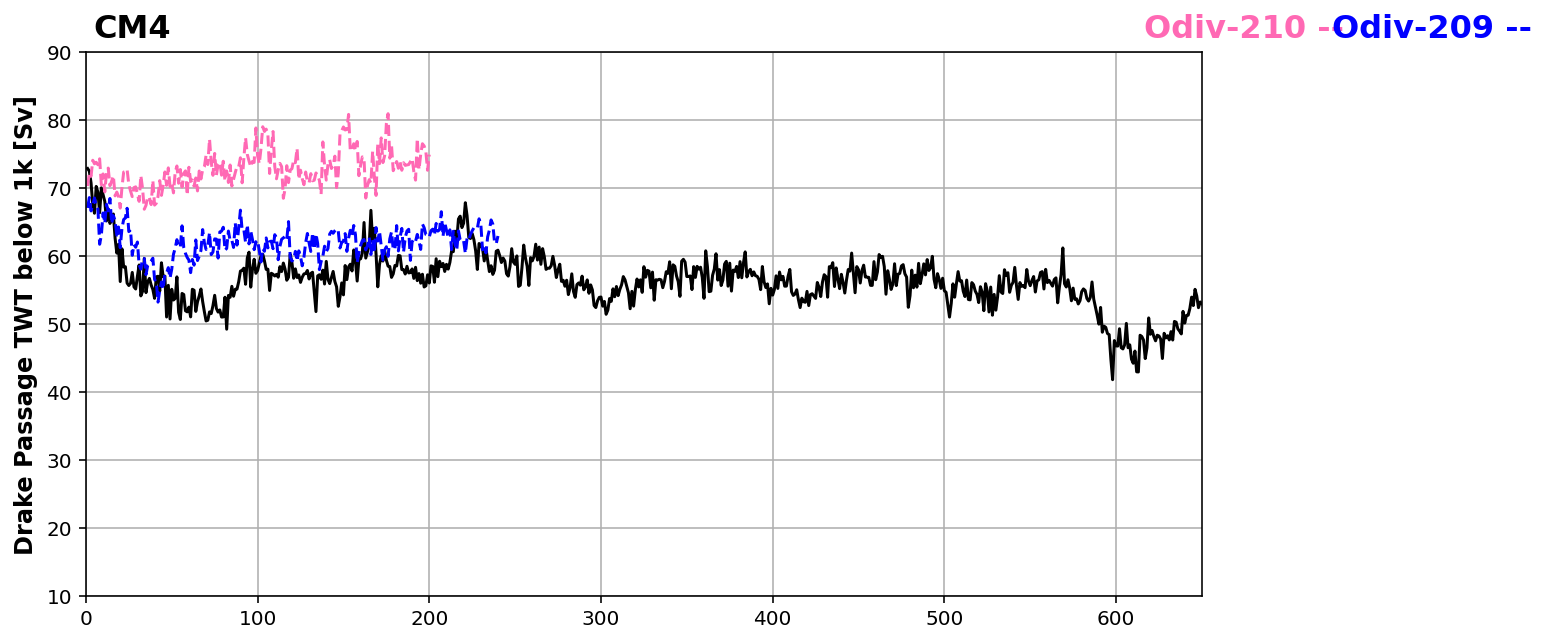

In [22]:
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(TWT_cmip6_below1000_annual_mean.time.dt.year,TWT_cmip6_below1000_annual_mean.values,color='black')
#plt.plot(TWT_170_below1000_annual_mean.time.dt.year,TWT_170_below1000_annual_mean.values,color='green')
#plt.plot(TWT_183_184_below1000_annual_mean.time.dt.year,TWT_183_184_below1000_annual_mean.values,color='blue')
#plt.plot(TWT_191_below1000_annual_mean.time.dt.year,TWT_191_below1000_annual_mean.values,color='red')
#plt.plot(TWT_200_below1000_annual_mean.time.dt.year,TWT_200_below1000_annual_mean.values,color='cyan')
#plt.plot(TWT_206_below1000_annual_mean.time.dt.year,TWT_206_below1000_annual_mean.values,color='hotpink')
#plt.plot(TWT_207_below1000_annual_mean.time.dt.year,TWT_207_below1000_annual_mean.values,color='orange')
plt.plot(TWT_209_below1000_annual_mean.time.dt.year,TWT_209_below1000_annual_mean.values,color='blue',linestyle='--')
plt.plot(TWT_210_below1000_annual_mean.time.dt.year,TWT_210_below1000_annual_mean.values,color='hotpink',linestyle='--')


ax.set_ylabel('Drake Passage TWT below 1k [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(10,90)
plt.xlim(0,650)


fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

Text(0.5, 1.0, '')

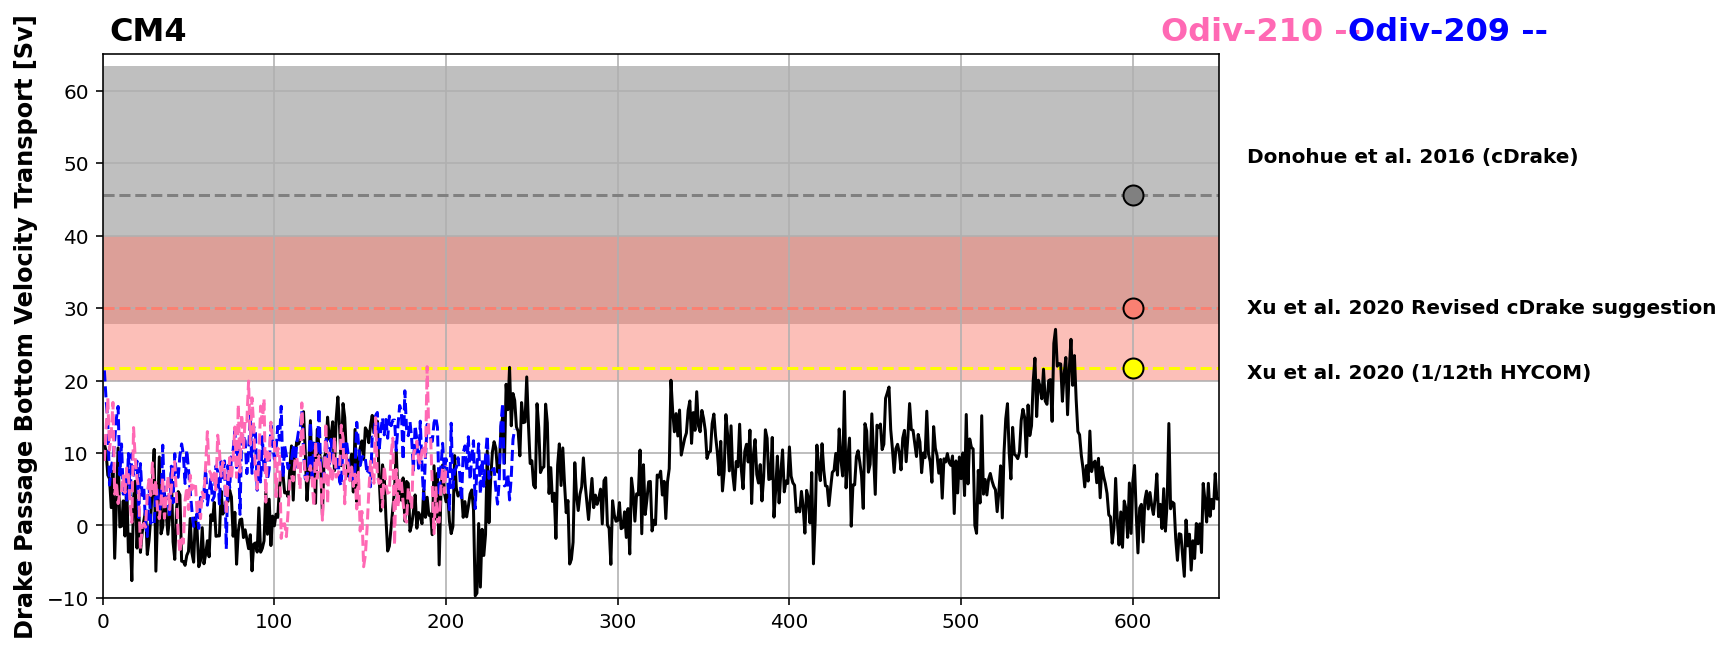

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

x_end = 600

x_all = (0,650)

y_cDrake = (27.8)
y1_cDrake = (63.4)
y2_cDrake = (45.6)  ## Value of 127.7 +/- 8.1 Sv (standard dev) from Chidichimo et al. 2014

Xu_revised_cDrake = (30)
Xu_revised_cDrake_upper = (40) 
Xu_revised_cDrake_lower = (20)

Xu_2020 = (21.7)

ax.fill_between(x_all,y_cDrake,y1_cDrake,facecolor='grey',alpha=0.5)
ax.fill_between(x_all,Xu_revised_cDrake_lower,Xu_revised_cDrake_upper,facecolor='salmon',alpha=0.5)

plt.axhline(y=45.6,linestyle='--',color='grey')
plt.axhline(y=21.7,linestyle='--',color='yellow')
plt.axhline(y=30,linestyle='--',color='salmon')

plt.plot(BVT_cmip6_annual_mean.time.dt.year,BVT_cmip6_annual_mean.values,color='black')
#plt.plot(BVT_170_annual_mean.time.dt.year,BVT_170_annual_mean.values,color='green')
#plt.plot(BVT_183_184_annual_mean.time.dt.year,BVT_183_184_annual_mean.values,color='blue')
#plt.plot(BVT_191_annual_mean.time.dt.year,BVT_191_annual_mean.values,color='red')
#plt.plot(BVT_200_annual_mean.time.dt.year,BVT_200_annual_mean.values,color='cyan')
#plt.plot(BVT_206_annual_mean.time.dt.year,BVT_206_annual_mean.values,color='hotpink')
#plt.plot(BVT_207_annual_mean.time.dt.year,BVT_207_annual_mean.values,color='orange')
plt.plot(BVT_209_annual_mean.time.dt.year,BVT_209_annual_mean.values,color='blue',linestyle='--')
plt.plot(BVT_210_annual_mean.time.dt.year,BVT_210_annual_mean.values,color='hotpink',linestyle='--')

ax.set_ylabel('Drake Passage Bottom Velocity Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(-10,65)
plt.xlim(0,650)

plt.plot(x_end,y2_cDrake,marker='o',markersize=10,markerfacecolor='grey',markeredgecolor='k')
plt.plot(x_end,Xu_revised_cDrake,marker='o',markersize=10,markerfacecolor='salmon',markeredgecolor='k')
plt.plot(x_end,Xu_2020,marker='o',markersize=10,markerfacecolor='yellow',markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

fig.text(0.92,0.73,'Donohue et al. 2016 (cDrake)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.43,'Xu et al. 2020 (1/12th HYCOM)',fontsize=10,color='black',fontweight='bold')
fig.text(0.92,0.52,'Xu et al. 2020 Revised cDrake suggestion',fontsize=10,color='black',fontweight='bold')

plt.title('')

Text(0.92, 0.55, 'Xu et al. 2020 (1/12th HYCOM)')

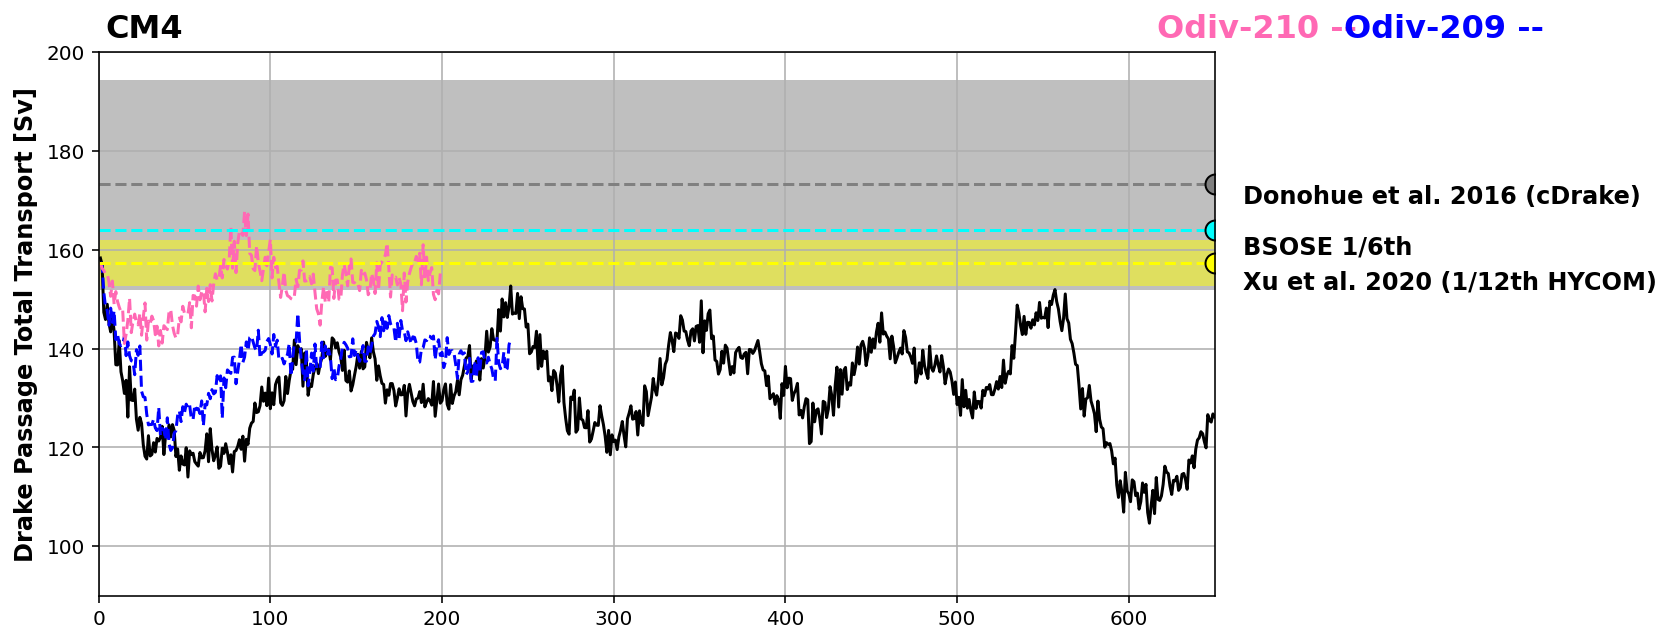

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(Total_UMO_cmip6_annual_mean.time.dt.year,Total_UMO_cmip6_annual_mean.values,color='black')
#plt.plot(Total_UMO_170_annual_mean.time.dt.year,Total_UMO_170_annual_mean.values,color='green')
#plt.plot(Total_UMO_183_184_annual_mean.time.dt.year,Total_UMO_183_184_annual_mean.values,color='blue')
#plt.plot(Total_UMO_191_annual_mean.time.dt.year,Total_UMO_191_annual_mean.values,color='red')
#plt.plot(Total_UMO_200_annual_mean.time.dt.year,Total_UMO_200_annual_mean.values,color='cyan')
#plt.plot(Total_UMO_206_annual_mean.time.dt.year,Total_UMO_206_annual_mean.values,color='hotpink')
#plt.plot(Total_UMO_207_annual_mean.time.dt.year,Total_UMO_207_annual_mean.values,color='orange')
plt.plot(Total_UMO_209_annual_mean.time.dt.year,Total_UMO_209_annual_mean.values,color='blue',linestyle='--')
plt.plot(Total_UMO_210_annual_mean.time.dt.year,Total_UMO_210_annual_mean.values,color='hotpink',linestyle='--')

x_end = 650
x_Donohue = (0,650)
y1_Donohue = (151.9)
y2_Donohue = (194.4)
y3_Donohue = (173.3)

y_Xu2020 = (157.3)
y1_Xu2020 = (161.9)
y2_Xu2020 = (152.7)

y_BSOSE = (164)

ax.fill_between(x_Donohue,y1_Donohue,y2_Donohue,facecolor='grey',alpha=0.5)
ax.fill_between(x_Donohue,y1_Xu2020,y2_Xu2020,facecolor='yellow',alpha=0.5)

ax.set_ylabel('Drake Passage Total Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(90,200)
plt.xlim(0,650)
plt.axhline(y=173.3,linestyle='--',color='grey')
plt.axhline(y=164,linestyle='--',color='cyan')
plt.axhline(y=157.3,linestyle='--',color='yellow')
ax.set_title('')

plt.plot(x_end,
         y3_Donohue,
         marker='o',
         markersize=10,
         markerfacecolor='grey',
         markeredgecolor='k')
plt.plot(x_end,
         y_BSOSE,
         marker='o',
         markersize=10,
         markerfacecolor='cyan',
         markeredgecolor='k')
plt.plot(x_end,
         y_Xu2020,
         marker='o',
         markersize=10,
         markerfacecolor='yellow',
         markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

fig.text(0.92,0.67,'Donohue et al. 2016 (cDrake)',fontsize=12,color='black',fontweight='bold')
fig.text(0.92,0.60,'BSOSE 1/6th',fontsize=12,color='black',fontweight='bold')
fig.text(0.92,0.55,'Xu et al. 2020 (1/12th HYCOM)',fontsize=12,color='black',fontweight='bold')

Text(0.92, 0.67, 'Firing et al. 2011 (SADCP)')

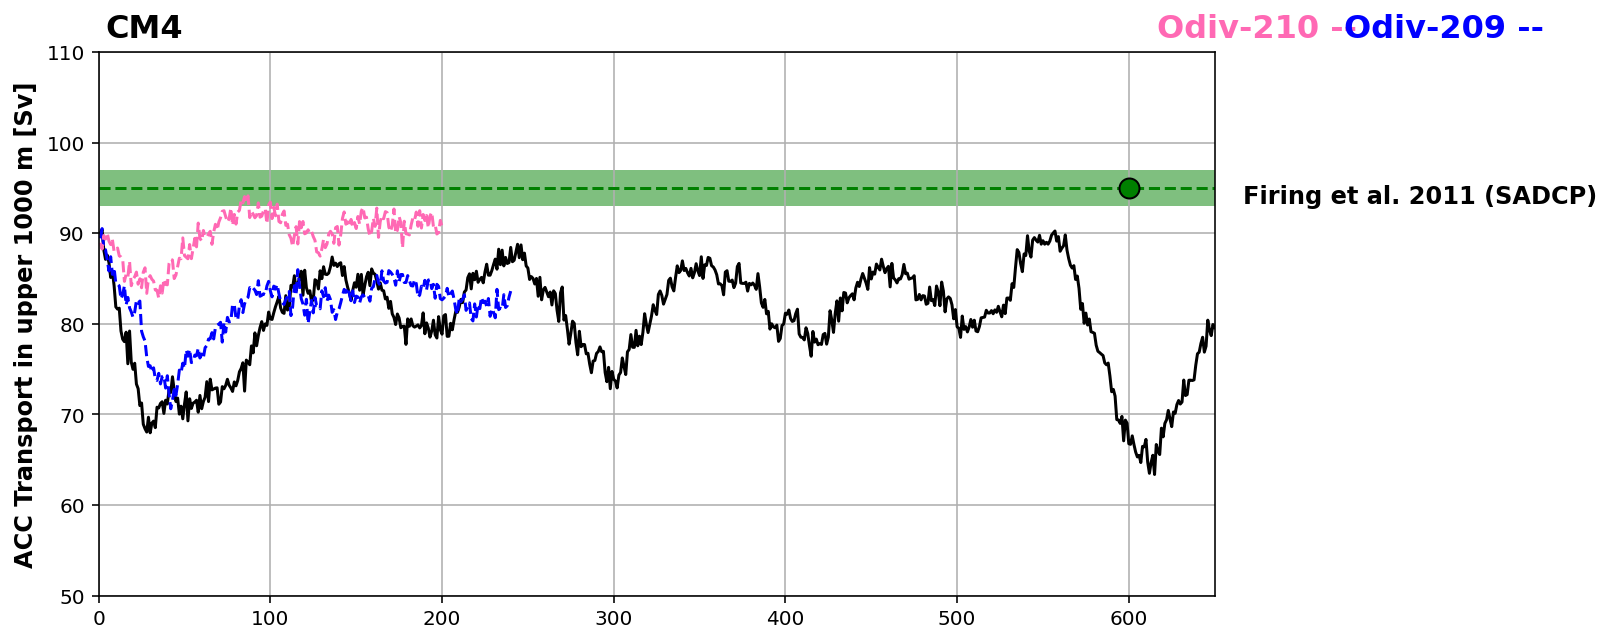

In [25]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(Total_UMO_cmip6_upper1000_annual_mean.time.dt.year,Total_UMO_cmip6_upper1000_annual_mean.values,color='black')
#plt.plot(Total_UMO_170_upper1000_annual_mean.time.dt.year,Total_UMO_170_upper1000_annual_mean.values,color='green')
#plt.plot(Total_UMO_183_184_upper1000_annual_mean.time.dt.year,Total_UMO_183_184_upper1000_annual_mean.values,color='blue')
#plt.plot(Total_UMO_191_upper1000_annual_mean.time.dt.year,Total_UMO_191_upper1000_annual_mean.values,color='red')
#plt.plot(Total_UMO_200_upper1000_annual_mean.time.dt.year,Total_UMO_200_upper1000_annual_mean.values,color='cyan')
#plt.plot(Total_UMO_206_upper1000_annual_mean.time.dt.year,Total_UMO_206_upper1000_annual_mean.values,color='hotpink')
#plt.plot(Total_UMO_207_upper1000_annual_mean.time.dt.year,Total_UMO_207_upper1000_annual_mean.values,color='orange')
plt.plot(Total_UMO_209_upper1000_annual_mean.time.dt.year,Total_UMO_209_upper1000_annual_mean.values,color='blue',linestyle='--')
plt.plot(Total_UMO_210_upper1000_annual_mean.time.dt.year,Total_UMO_210_upper1000_annual_mean.values,color='hotpink',linestyle='--')

x_end = 600

x_all = (0,650)
y_Firing = (95)
y1_Firing = (93)
y2_Firing = (97)


ax.fill_between(x_all,y1_Firing,y2_Firing,facecolor='green',alpha=0.5)

ax.set_ylabel('ACC Transport in upper 1000 m [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(50,110)
plt.xlim(0,650)
plt.axhline(y=95,linestyle='--',color='green')

plt.plot(x_end,y_Firing,marker='o',markersize=10,markerfacecolor='green',markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
#fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
#fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
#fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
#fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
#fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')
#fig.text(0.86,0.90,'Odiv-207',fontsize=16,color='orange',fontweight='bold')
#fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.86,0.90,'Odiv-210 --',fontsize=16,color='hotpink',fontweight='bold')
fig.text(0.99,0.90,'Odiv-209 --',fontsize=16,color='blue',fontweight='bold')

fig.text(0.92,0.67,'Firing et al. 2011 (SADCP)',fontsize=12,color='black',fontweight='bold')